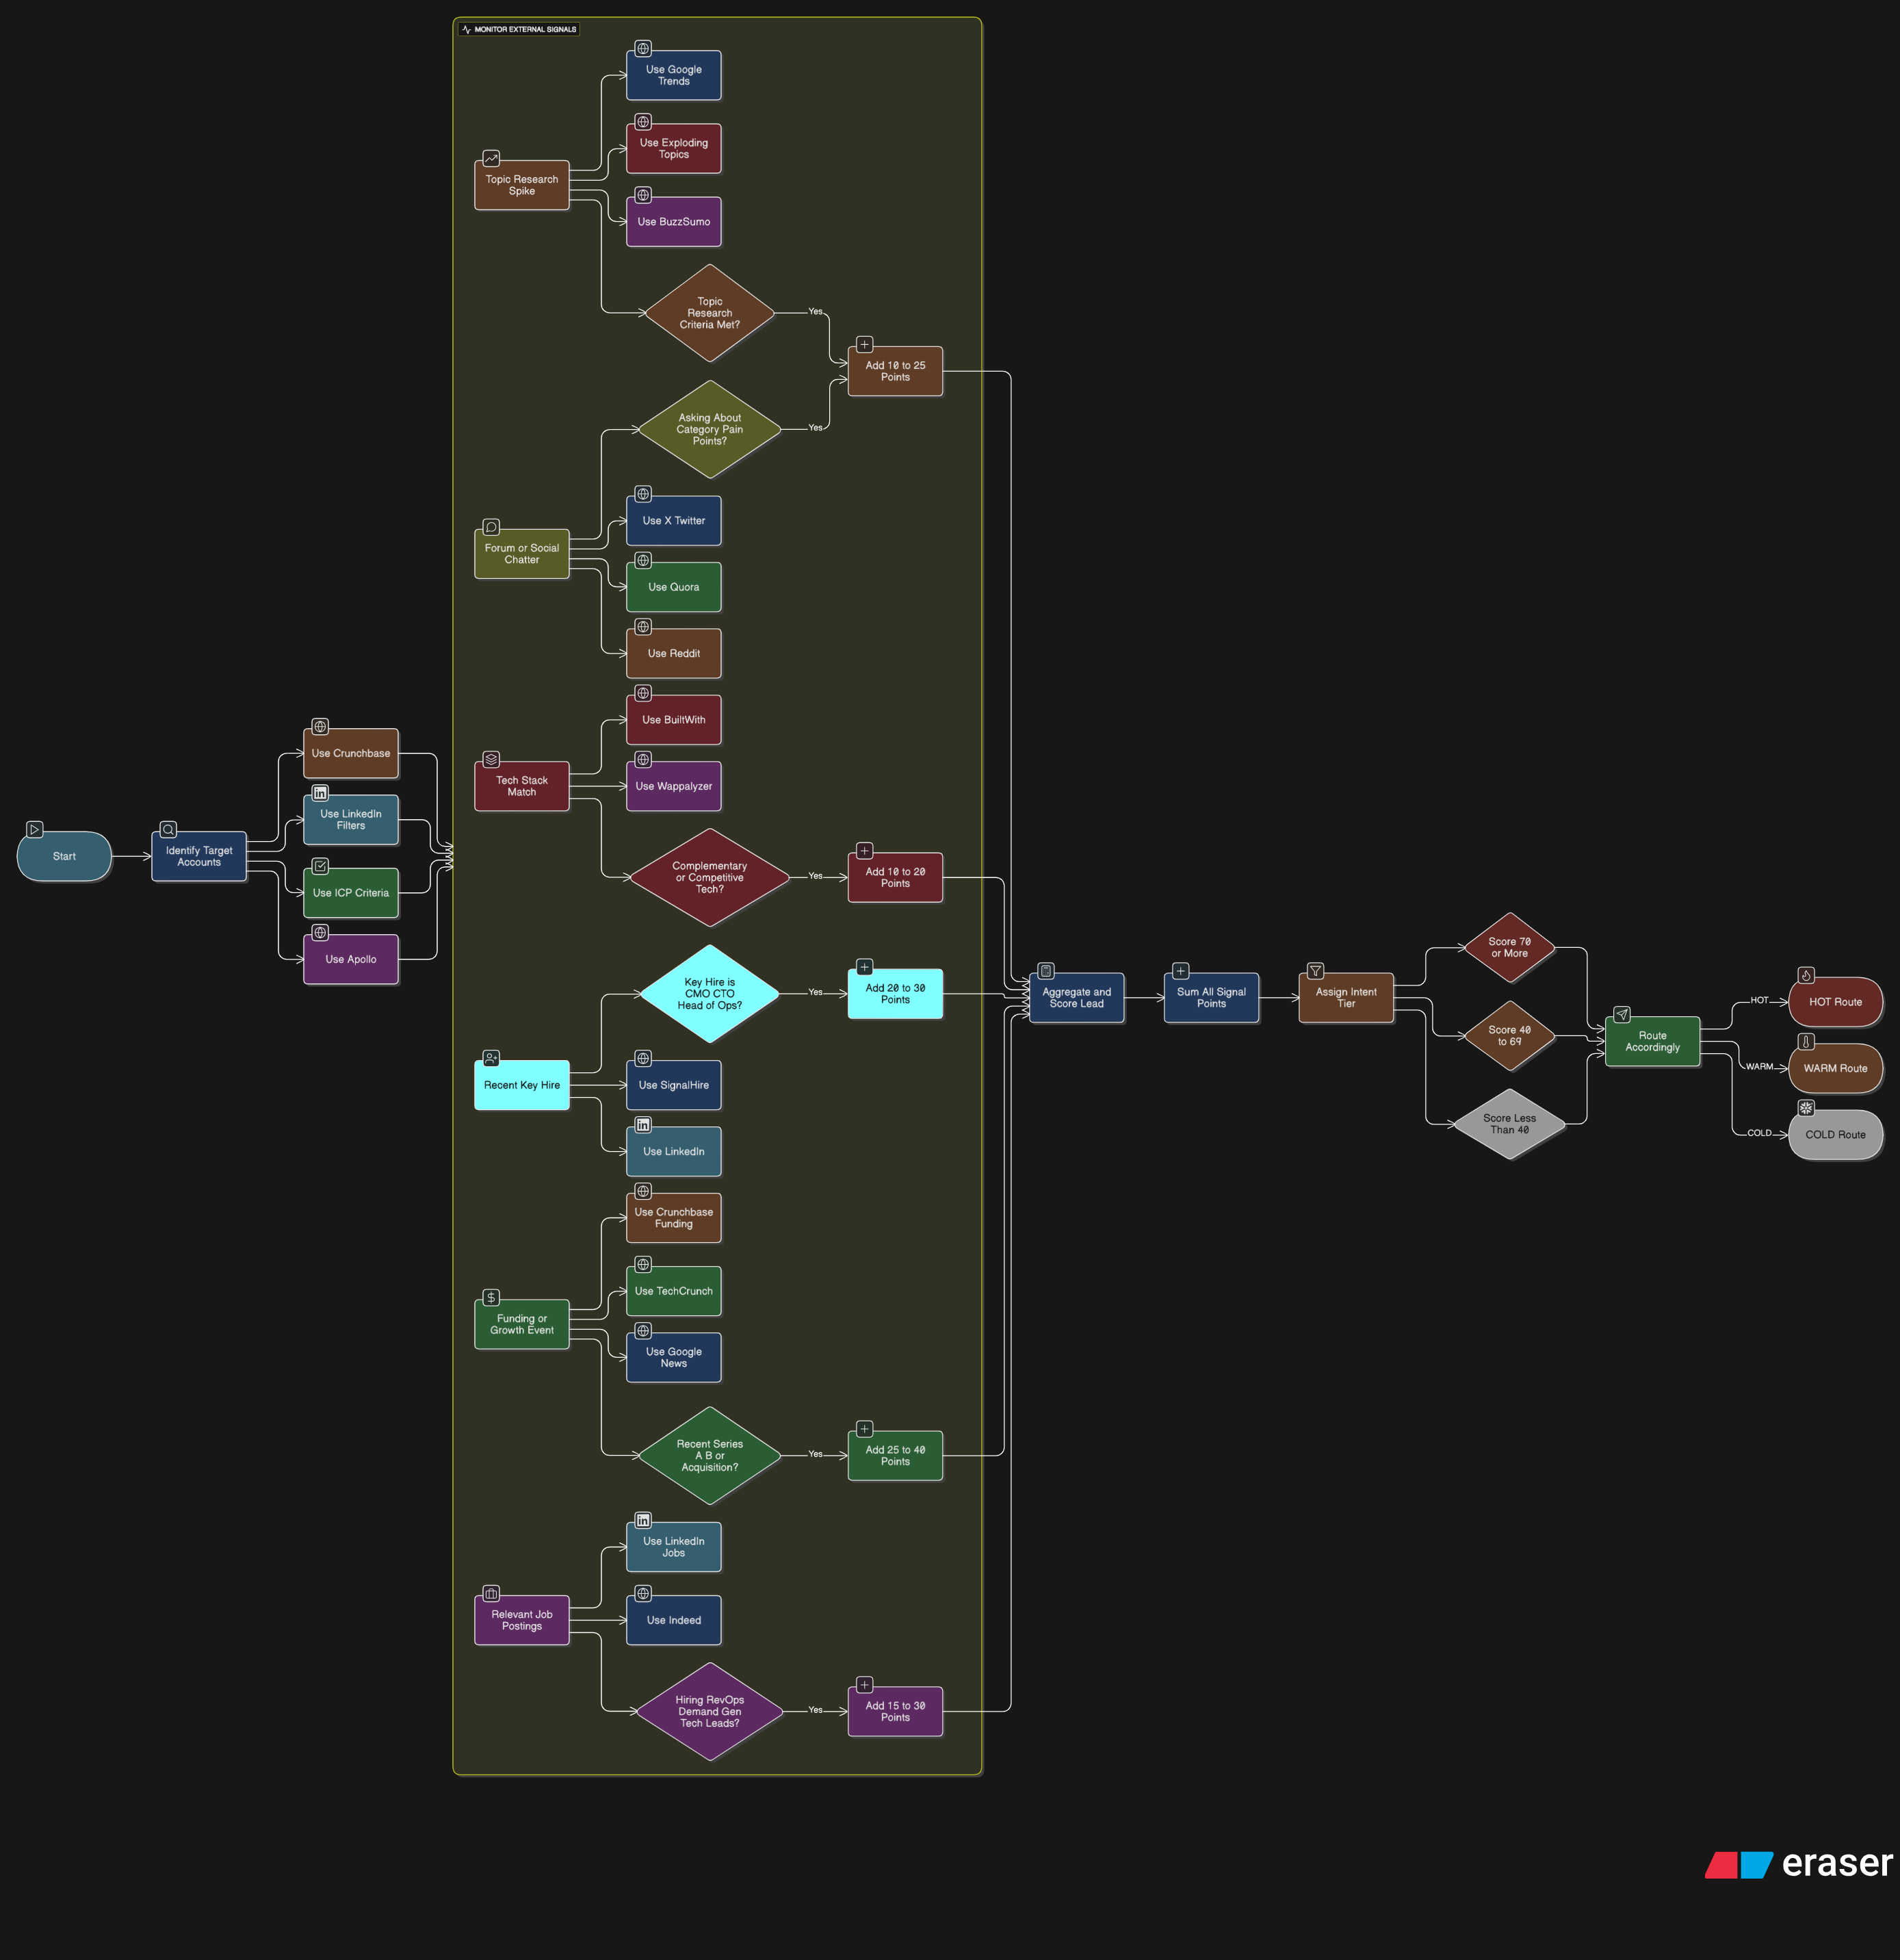

In [2]:
!pip install feedparser beautifulsoup4 requests

In [7]:
import feedparser
import csv
from datetime import datetime

GOOGLE_NEWS_FEEDS = [
    "https://news.google.com/rss/search?q=cloud+security",
    "https://news.google.com/rss/search?q=vulnerability+management"
]

def fetch_news_rss(feed_urls):
    results = []
    for url in feed_urls:
        feed = feedparser.parse(url)
        for entry in feed.entries:
            results.append({
                "source": "Google News",
                "title": entry.title,
                "link": entry.link,
                "published": entry.published if 'published' in entry else datetime.today().strftime('%Y-%m-%d')
            })
    return results

def save_to_csv(data, filename="topic_mentions.csv"):
    with open(filename, "w", newline="", encoding="utf-8") as f:
        writer = csv.DictWriter(f, fieldnames=["source", "title", "link", "published"])
        writer.writeheader()
        writer.writerows(data)
    print(f"Saved {len(data)} records to {filename}")

# Run
data = fetch_news_rss(GOOGLE_NEWS_FEEDS)
save_to_csv(data)


Saved 200 records to topic_mentions.csv


In [8]:
from google.colab import files
files.download("topic_mentions.csv")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
!pip install feedparser transformers

In [1]:
# 🔹 Step 2: Import libraries
import feedparser
import csv
import os
from datetime import datetime
from transformers import pipeline
from google.colab import files

# 🔹 Step 3: Configuration

ICP_COMPANIES = [
    "Qualys",
    "CrowdStrike",
    "Tenable",
    "Rapid7",
    "Palo Alto Networks"
]

INTENT_KEYWORDS = [
    "RFP", "looking for", "partner", "implementing", "evaluation",
    "adopting", "selecting", "deploy", "cybersecurity upgrade",
    "bug bounty", "DevSecOps", "expansion", "CISO", "security breach"
]

TRUSTED_SOURCES = ["forbes.com", "gartner.com", "techcrunch.com", "zdnet.com"]

# 🔹 Step 4: Hugging Face classifier
classifier = pipeline("zero-shot-classification", model="facebook/bart-large-mnli")

def get_relevance_reason(title, company):
    hypothesis_template = "This headline suggests the company is {}"
    labels = [
        "looking to buy cybersecurity tools",
        "expanding security capabilities",
        "evaluating security vendors",
        "experiencing a cybersecurity issue",
        "not related to cybersecurity intent"
    ]
    try:
        result = classifier(title, labels, hypothesis_template=hypothesis_template)
        top_label = result["labels"][0]
        top_score = result["scores"][0]
        if top_score > 0.6 and top_label != "not related to cybersecurity intent":
            return top_label
        else:
            return "Low/no buying intent"
    except Exception as e:
        print("⚠️ HF error:", e)
        return "N/A"

# 🔹 Step 5: Scoring and fetching logic

def generate_rss_url(company_name):
    query = company_name.replace(" ", "+")
    return f"https://news.google.com/rss/search?q={query}"

def fetch_company_mentions(company_list):
    all_mentions = []
    for company in company_list:
        url = generate_rss_url(company)
        feed = feedparser.parse(url)
        for entry in feed.entries:
            all_mentions.append({
                "company": company,
                "title": entry.title,
                "link": entry.link,
                "published": entry.published if 'published' in entry else datetime.today().strftime('%Y-%m-%d')
            })
    return all_mentions

def score_mention(mention):
    score = 0
    title_lower = mention["title"].lower()

    matches = [kw for kw in INTENT_KEYWORDS if kw.lower() in title_lower]
    score += 3 * len(matches)

    try:
        pub_date = datetime.strptime(mention["published"][:10], "%Y-%m-%d")
        if (datetime.today() - pub_date).days <= 7:
            score += 2
    except:
        pass

    for domain in TRUSTED_SOURCES:
        if domain in mention["link"]:
            score += 2
            break

    return score

# 🔹 Step 6: Save/load helpers

def load_seen_links(file="seen.csv"):
    if not os.path.exists(file):
        return set()
    with open(file, newline="", encoding="utf-8") as f:
        return set(row["link"] for row in csv.DictReader(f))

def save_seen_links(links, file="seen.csv"):
    with open(file, "w", newline="", encoding="utf-8") as f:
        writer = csv.DictWriter(f, fieldnames=["link"])
        writer.writeheader()
        for link in links:
            writer.writerow({"link": link})

def save_new_mentions_with_scores_and_reasons(data, file="new_mentions.csv"):
    for item in data:
        item["score"] = score_mention(item)
        if item["score"] >= 5:
            item["reason"] = get_relevance_reason(item["title"], item["company"])
        else:
            item["reason"] = "Low score"

    with open(file, "w", newline="", encoding="utf-8") as f:
        writer = csv.DictWriter(f, fieldnames=["company", "title", "link", "published", "score", "reason"])
        writer.writeheader()
        writer.writerows(data)

    print(f"✅ Scored, tagged and saved {len(data)} mentions to {file}")

# 🔹 Step 7: Run pipeline

seen_links = load_seen_links()
all_mentions = fetch_company_mentions(ICP_COMPANIES)
new_mentions = [m for m in all_mentions if m["link"] not in seen_links]
updated_links = seen_links.union(m["link"] for m in new_mentions)
save_new_mentions_with_scores_and_reasons(new_mentions)
save_seen_links(updated_links)

# 🔹 Step 8: Download CSV
files.download("new_mentions.csv")


  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.3/81.3 kB 3.1 MB/s eta 0:00:00
  Created wheel for sgmllib3k: filename=sgmllib3k-1.0.0-py3-none-any.whl size=6046 sha256=748a42c877208bceb79c3fa02d24f06b025dbe2cdbc5330ae57ae45b5ef4a629
  Stored in directory: /root/.cache/pip/wheels/3b/25/2a/105d6a15df6914f4d15047691c6c28f9052cc1173e40285d03
Successfully built sgmllib3k


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/1.15k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Device set to use cpu


✅ Scored, tagged and saved 500 mentions to new_mentions.csv


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [2]:
import pandas as pd

df = pd.read_csv("new_mentions.csv")
pd.set_option('display.max_colwidth', None)  # Optional: show full headlines
df.head(10)  # Show first 10 rows


company  \
0  Qualys   
1  Qualys   
2  Qualys   
3  Qualys   
4  Qualys   
5  Qualys   
6  Qualys   
7  Qualys   
8  Qualys   
9  Qualys   

                                                                                                                                            title  \
0                                                                    Microsoft and Adobe Patch Tuesday, June 2025 Security Update Review - Qualys   
1                                                                   Qualys (NASDAQ:QLYS) Lowered to "Hold" Rating by Wall Street Zen - MarketBeat   
2                                 Silicon Valley firm Qualys opens D.C. office amid growing federal cloud security market - The Business Journals   
3                                                    Qualys Expands Public Sector Footprint with Opening of Washington, D.C. Office - PR Newswire   
4                         Qualys Strengthens Government Cybersecurity Presence with New DC Office, Nears FedRAMP High Authorization - Stock Titan   
5                                                            Zacks Industry Outlook Highlights CyberArk Software, Okta and Qualys - Yahoo Finance   
6                                                                        Qualys Gets Relative Strength Rating Upgrade - Investor's Business Daily   
7  Qualys TRU Discovers Two Local Information Disclosure Vulnerabilities in Apport and systemd-coredump: CVE-2025-5054 and CVE-2025-4598 - Qualys   
8                                                                  Introducing Qualys Policy Audit, the New Standard for Audit Readiness - Qualys   
9                                                                      Safeguarding Vulnerability Management Despite MITRE Funding Risks - Qualys   

                                                                                                                                                                                                                                                                                                                                                                                                                                                        link  \
0                                                                                                                       https://news.google.com/rss/articles/CBMizgFBVV95cUxObTZtM0g1U0RETFdlenI2WFBWU0k0YzVzOGNEMGxWMmxyM2RQc3RuamotZE1HczVicEpwUHNQQXdVaExOZl9CMjZRMFh6WFNqeEhNWjNLZHBYZDJXeTR5bFVMQU9IUm40cFJueGVRanh0bG9lVkxjMXJuS3JFSFZzZFlrdUlkSXhyeWFhZDNNV1hPNjlpaldFVThwLXNoNlVNbUVjRmdkc1VwUmplWW9zVXRoNHJvWE5XUnBJWHBFRWtPeXN2V3luVDN2YzBsdw?oc=5   
1                                                                                                                                                           https://news.google.com/rss/articles/CBMiswFBVV95cUxOajFTTVhRVFV3NU9kTjljSlotNlJRdDJONHZTUWU1T1RlOUJXV0wyQzFIVEFhV1RCMlN0OWpUZlFKMGRsM0hYakdSSFpQcEwyZTAxUkhLVm0zZUt6Tmo3by1KS3lrbVJMYmdxZzdYc01ycHNydXFoTnZfMXowcWNHQ2VPT3FKSnBOSVh0ZG56RXdJMGdXUHNLMHpyVlo0MkNQODRVdU5RazVVWGg0S3cycG9uaw?oc=5   
2                                                                                                                                             https://news.google.com/rss/articles/CBMivgFBVV95cUxPeC1qalVNOFFkZjFZYnNTSkN5Tlp4QWNDYWFJaDBuX1hwME1TaG1JRWdXQk9CSXl3aE9Ga2hqa0hNN09vYzc5RXBBSnlKLW5PTDRHMUl3ZEhjR2dpSFB4eWpxV00yWWcyV19lUk9OYkQ4c1ZTdTZ4Q1BzVHJmbEtOMGFkLTlMVTFnT1ZRN2pMQjhxRjhQWDlNa0t4dTVWWHRUcF9EWGJjOTN2N1RPOTNpN2J2LXNtM1hlU3hGSGNB?oc=5   
3                                                                                                                           https://news.google.com/rss/articles/CBMiywFBVV95cUxPWWQ4OXMwTFNQeHlFcGtRQUdaR2p6T1RybjN5b0V5M2U0VTZERVVXSDZ4R1RjeUM5V3ZXRTI2eGVoRy1zNGhfYm1RRkJIRU9MQ3BfaUhiYkRmMVlpNVQtTzRIdk0wVTk0aUMtRzFyRXBmZnpadExyQk1qcktERzl2R2RxVlFYdmNGVEJDbVdIUDhfQjJ5aU40Wk8tblU0dlIwYjVfVHZPdHM2X3VRZDBsQXFFcUZON05KWmJIaVBZcTBCQ

In [3]:
intent_matches = [kw for kw in INTENT_KEYWORDS if kw.lower() in df.iloc[0]['title'].lower()]
print("Matching keywords:", intent_matches)


Matching keywords: []


In [4]:
test_mention = {
    "title": "Qualys partners with AWS to expand DevSecOps offering",
    "link": "https://forbes.com/example",
    "published": "2025-06-13"
}

print("Score:", score_mention(test_mention))


Score: 10


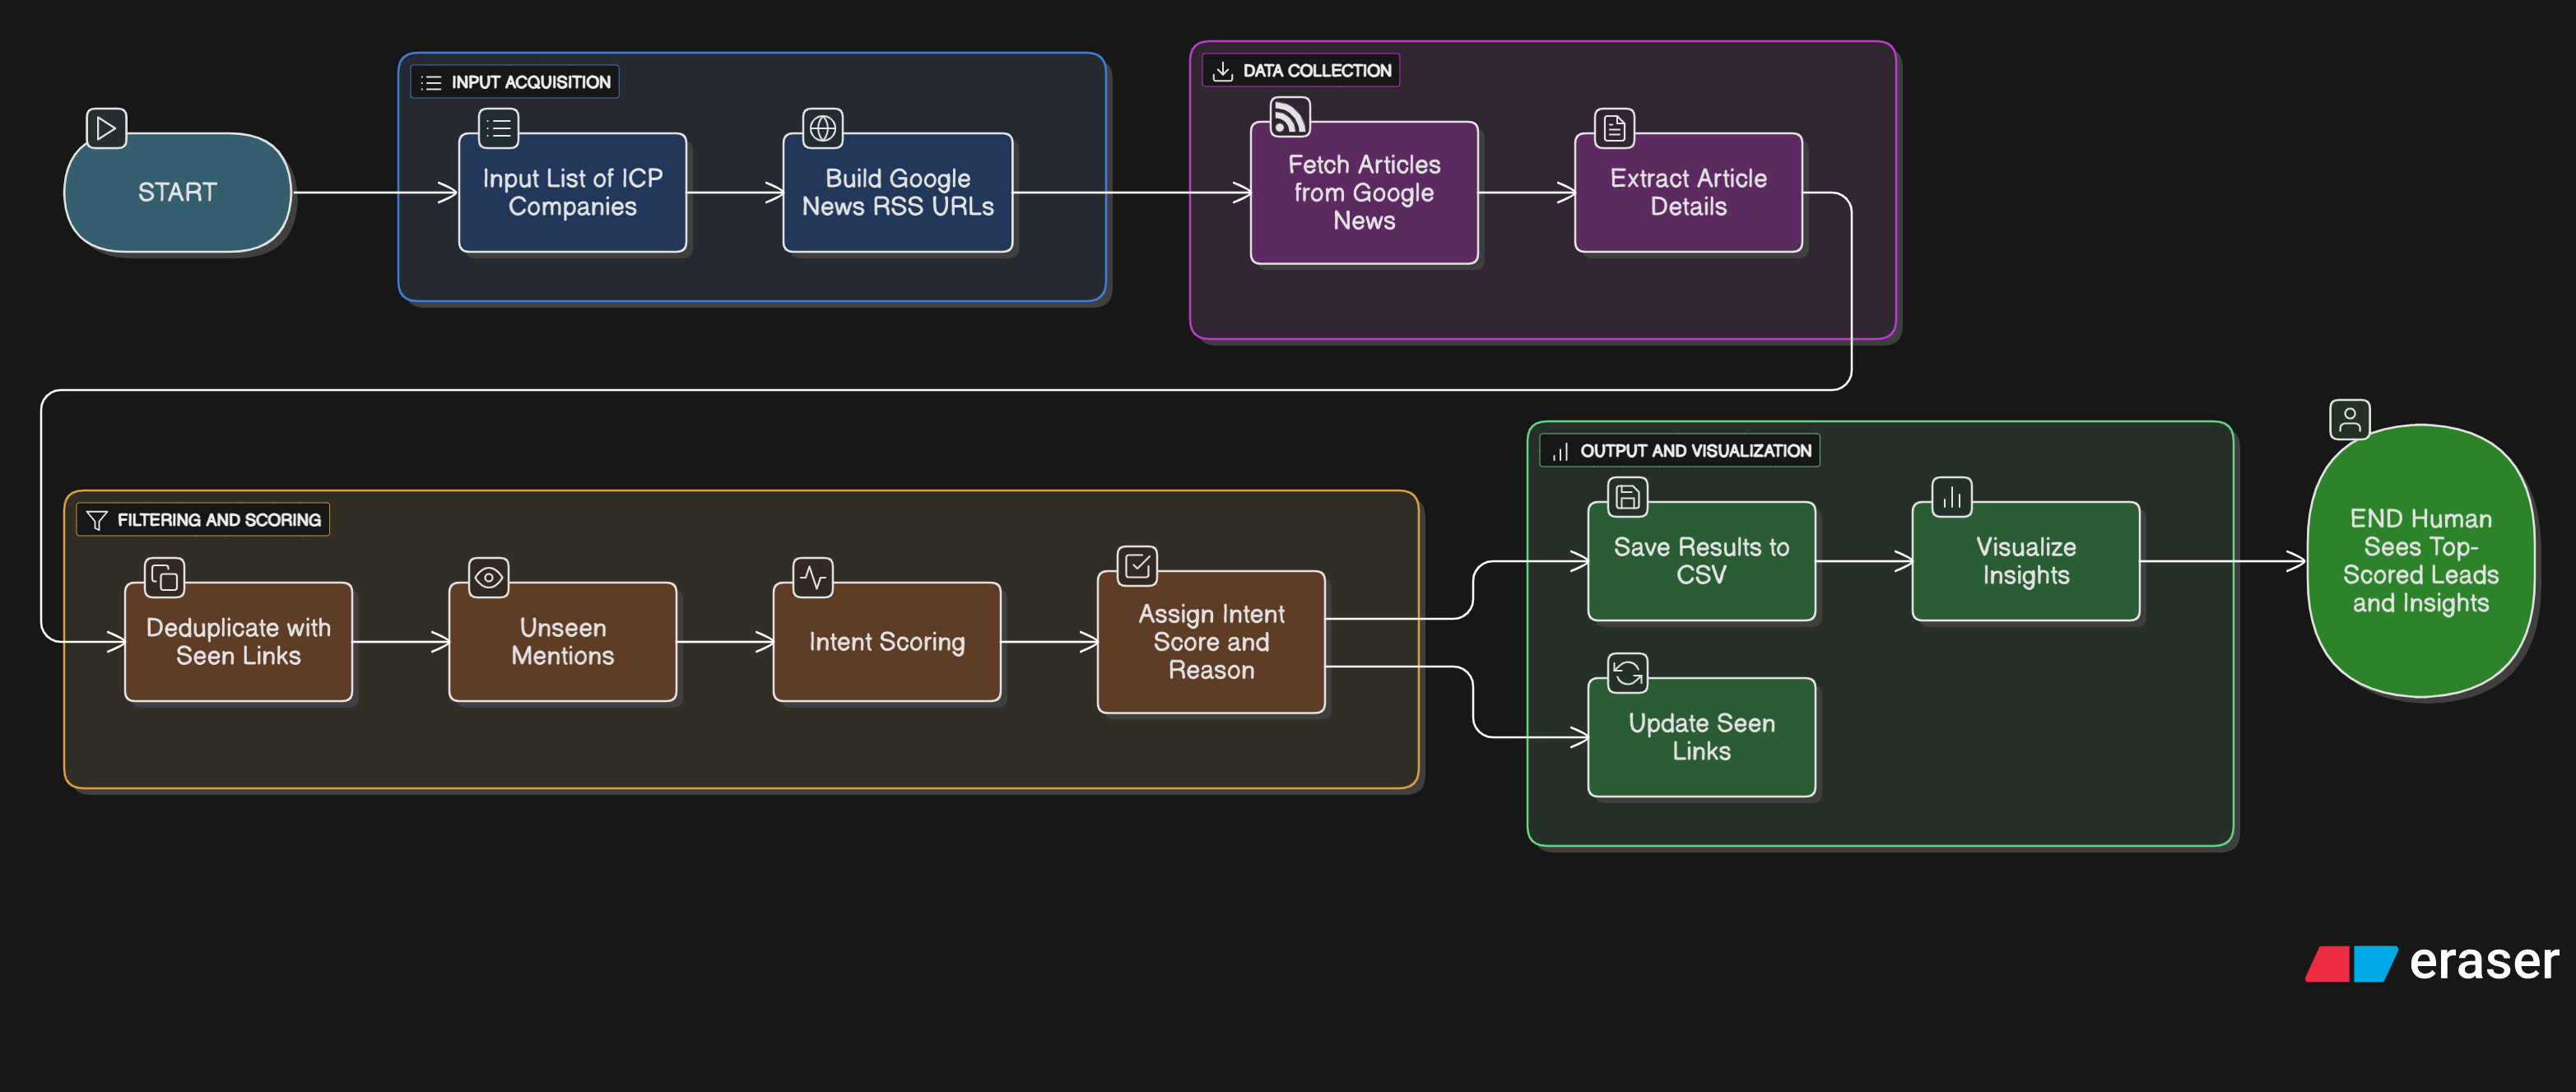

🔍 Fetching news for CrowdStrike...
🔍 Fetching news for Tenable...
🔍 Fetching news for Rapid7...
🔍 Fetching news for Palo Alto Networks...
✅ Scored and saved 166 rows to scored_mentions.csv


company  \
312  Palo Alto Networks   
111             Tenable   
187             Tenable   
97          CrowdStrike   
164             Tenable   
77          CrowdStrike   
146             Tenable   
357  Palo Alto Networks   
235              Rapid7   
265              Rapid7   

                                                                                                                           title  \
312                    Palo Alto Networks expands cloud presence in Asia-Pacific and Japan to strengthen cybersecurity - ET CISO   
111                                                          Tenable To Buy Apex Security To Help Reduce Cyber Risks - Pulse 2.0   
187             Tenable enhances cloud security with new data and AI security posture management capabilities - Industrial Cyber   
97                                                                    Cybersecurity for Small Business | Solutions - CrowdStrike   
164                                       Tenable to acquire Apex Security, bolstering AI risk control - SecurityBrief Australia   
77                                                                    Managed and On-Demand Cybersecurity Services - CrowdStrike   
146  Tenable acquires Vulcan Cyber, Chinese and Iranian hackers are using U.S. AI, US Navy bans use of DeepSeek - cisoseries.com   
357                        Palo Alto Networks buys Protect AI for reported $500M+, debuts new cybersecurity tools - SiliconANGLE   
235                     Rapid7, Inc. (RPD): Among the Best Cybersecurity Stocks to Buy According to Billionaires - Yahoo Finance   
265                                                   The 2025 Tech Power Players in the cybersecurity sector - The Boston Globe   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   link  \
312  https://news.google.com/rss/articles/CBMi_gFBVV95cUxPZXBwMjQ4NHJpRGJTLTQxb2xwMEludzFDb3hQcUhfWDRkb1FaNE1iN1F4OHBURDdJNkd0SFNRTHd6NmIwQXo2cDVqYXg5bm8tZmJqNVVPQlhwMVpKanVqaFotQU1Ic2FIazRXUWVyN2dFdEVBRUotYUQ5dVNRdWRvOFlaR2UwNmhyUlZmOHFPUVQ3TDhQQVkxcW03OTJxZjlCbTU5U1NfNHNILUp0WEp3Q05FaVZUXzRuUkI5TWZKc19FZVFOSUlycTFxZkNHQVBsUk01a2xJRnNGVHdWZHgxMlBtSVVUd3cyNVIxQWd1OHlRYVJOTHV3US0xUUQtZ9IBgwJBVV95cUxNenp6eWgzam9zNTNjb3FQN0QzbVBMeDFZOXZQNXZFYXJieUNWRFFYaGY4QXUtdFUzaUlMMlFuU3BKUGw4THRfZGlpSmxwVzJWX1BqaHpGbXdON09jS2tRTG15QlkyeFQ4WlNqdkc1Q1Z3cVVwY2NHczlzU3dhbHNBNTV4YXEyYWdaTmNBNG9LWEk4RDRJOEcwZ0Y2UERVcnRqUm5aUnNFZGtFR2trb3BVWHoxb3c3RlVjS1JxNnV4T2lHNHo2cHhwV3JvZmcwU0J1aHFicVNMeTNWcFI3NFl2cW5BaGhUaHcwdXpEUXRFN1RobXduQlpMcnRpM1phQ01KeVkw?oc=5   
111                                                                                                                                                                                                                                                                                                                                                https://news.google.com/rss/articles/CBMigAFBVV95cUxOalBtdXlDaTFGdUxvWHE4WXZSN3JqLXl5VkNwQ3FMUDNoc2RXdVFleng1M0doSGlzX19vUHRRa3FGLWhxd3h0V1R6X3BiTk5meDFYaDJac1Y5QjBaNTBMVkkwYml3NWhZWDdfbzJGdmlMTGpiY05ha3ZzbHlwaV8wVdIBhgFBVV95cUxPazZTVXpmQVppblpOWXNpR0VScml4Zzd4REpUeXQtY2tjSHVoa3ZXaVg1QkY5WEhUTzhjUHUxSHBmWnJJWXRUbGRXSU00MGdtdUFTOWh5dDdBaU9GRmczVXhMcVpFVXMtdEVHWWlrd1Qtd3VPaFlqNnNMSmxma3hKTk5naUpjQQ?oc=5   
187                     

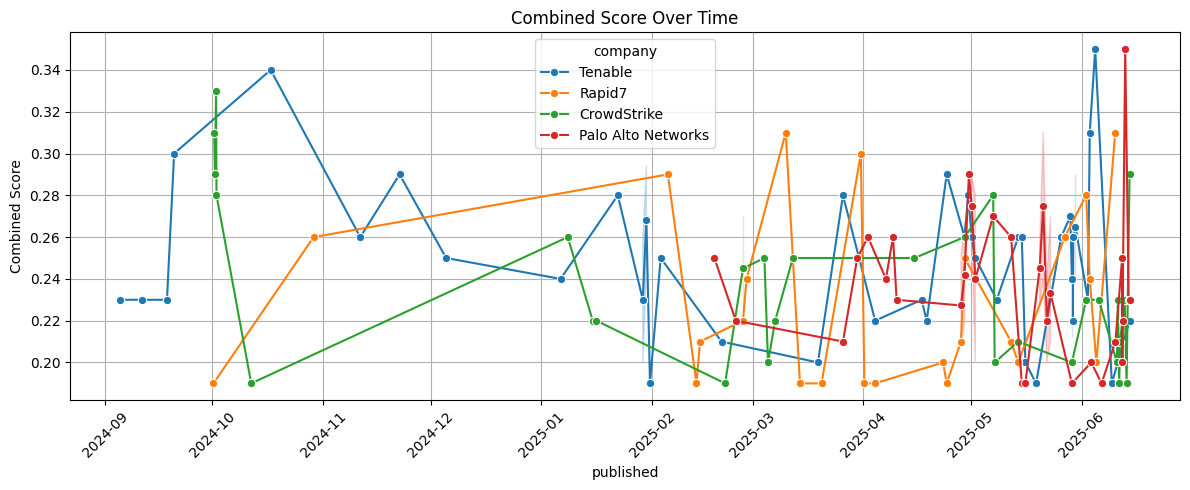

<ipython-input-5-1264612218>:154: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_companies.values, y=top_companies.index, palette="Blues_d")


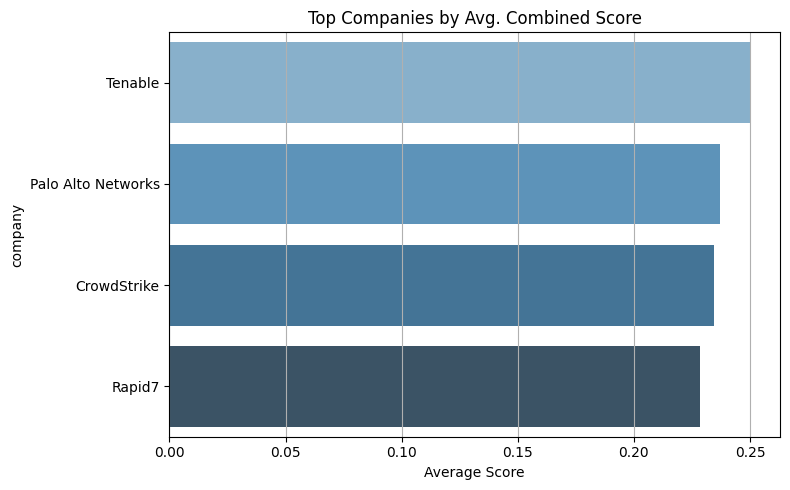

<ipython-input-5-1264612218>:163: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_reasons.values, y=top_reasons.index, palette="Greens_d")


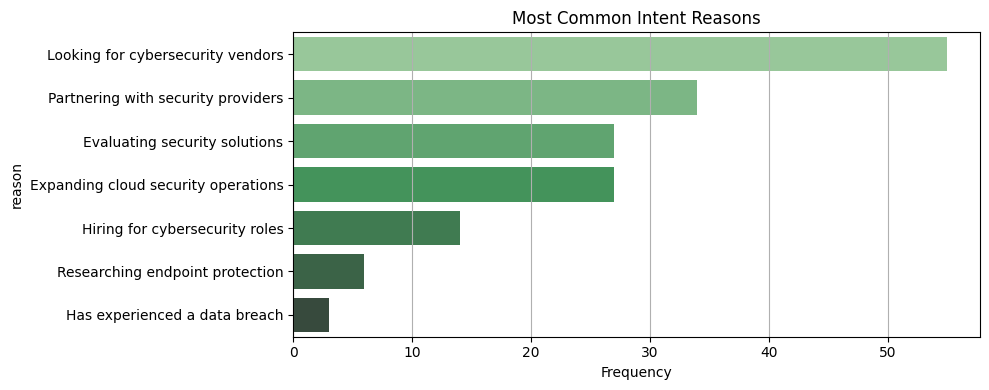

In [5]:
# ✅ FULL PIPELINE: ICP Firmographic Data Collection + Intent Scoring + Visuals (Free Resources)

# --- INSTALL DEPENDENCIES ---
!pip install feedparser beautifulsoup4 requests sentence-transformers seaborn matplotlib --quiet

# --- IMPORTS ---
import pandas as pd
import feedparser
import requests
from bs4 import BeautifulSoup
from sentence_transformers import SentenceTransformer, util
from urllib.parse import quote_plus
import matplotlib.pyplot as plt
import seaborn as sns
import time

# --- SETUP ---
icp_companies = [
     "CrowdStrike", "Tenable", "Rapid7", "Palo Alto Networks"
]

intent_prompts = [
    "Looking for cybersecurity vendors",
    "Researching endpoint protection",
    "Evaluating security solutions",
    "Has experienced a data breach",
    "Expanding cloud security operations",
    "Hiring for cybersecurity roles",
    "Partnering with security providers"
]

model = SentenceTransformer("sentence-transformers/all-MiniLM-L6-v2")

# --- STEP 1: Fetch News Mentions ---
def fetch_mentions(company):
    url = f"https://news.google.com/rss/search?q={quote_plus(company)}"
    feed = feedparser.parse(url)
    mentions = []
    for entry in feed.entries:
        mentions.append({
            "company": company,
            "title": entry.title,
            "link": entry.link,
            "published": entry.get("published", "")
        })
    return mentions

# --- STEP 2: Score Buying Intent ---
def score_intent(mention):
    title_embed = model.encode(mention["title"], convert_to_tensor=True)
    intent_embeds = model.encode(intent_prompts, convert_to_tensor=True)
    sims = util.cos_sim(title_embed, intent_embeds)[0]
    best_score = float(sims.max())
    best_prompt = intent_prompts[sims.argmax()]
    mention["intent_score"] = round(best_score, 2)
    mention["reason"] = best_prompt
    return mention

# --- STEP 3: Fetch BuiltWith Tech Stack ---
def fetch_tech_stack(company):
    search_url = f"https://builtwith.com/{quote_plus(company)}"
    try:
        response = requests.get(search_url, headers={"User-Agent": "Mozilla/5.0"}, timeout=10)
        soup = BeautifulSoup(response.text, "html.parser")
        tags = soup.find_all("a")
        tech_tags = [tag.get_text(strip=True) for tag in tags if "/technology/" in tag.get("href", "")]
        return ", ".join(set(tech_tags[:10]))
    except Exception as e:
        return ""

# --- STEP 4: Fetch LinkedIn Info via Search ---
def fetch_linkedin_info(company):
    url = f"https://www.google.com/search?q={quote_plus(company + ' site:linkedin.com/company')}"
    try:
        response = requests.get(url, headers={"User-Agent": "Mozilla/5.0"}, timeout=10)
        soup = BeautifulSoup(response.text, "html.parser")
        snippets = soup.find_all("span")
        joined_text = " ".join([s.get_text() for s in snippets])
        size = "Unknown"
        location = "Unknown"
        revenue = "Unknown"
        if "employees" in joined_text:
            start = joined_text.find("employees")
            size = joined_text[max(0, start-30):start+30].split("employees")[0].strip().split()[-3:]
            size = " ".join(size)
        if "headquartered" in joined_text:
            start = joined_text.find("headquartered")
            location = joined_text[start:start+50].split("in")[-1].split()[0:3]
            location = " ".join(location)
        if "$" in joined_text:
            dollar_idx = joined_text.find("$")
            revenue = joined_text[dollar_idx:dollar_idx+20].split()[0:3]
            revenue = " ".join(revenue)
        return size, location, revenue
    except Exception:
        return "Unknown", "Unknown", "Unknown"

# --- STEP 5: Score Based on Firmographic Match ---
def firmographic_score(company_data):
    score = 0
    if company_data["tech_stack"]:
        score += 1
    if company_data["employee_size"] and company_data["employee_size"] != "Unknown":
        score += 1
    if company_data["location"] and company_data["location"] != "Unknown":
        score += 1
    if company_data["revenue"] and company_data["revenue"] != "Unknown":
        score += 1
    return score / 4.0  # normalize to 0–1

# --- STEP 6: Run All Steps ---
all_mentions = []

for company in icp_companies:
    print(f"🔍 Fetching news for {company}...")
    mentions = fetch_mentions(company)
    tech_stack = fetch_tech_stack(company)
    size, location, revenue = fetch_linkedin_info(company)
    for m in mentions:
        m = score_intent(m)
        m["tech_stack"] = tech_stack
        m["employee_size"] = size
        m["location"] = location
        m["revenue"] = revenue
        m["firmographic_score"] = firmographic_score(m)
        m["combined_score"] = round((0.6 * m["intent_score"] + 0.4 * m["firmographic_score"]), 2)
        all_mentions.append(m)
    time.sleep(2)

# --- STEP 7: Save + Display ---
df = pd.DataFrame(all_mentions)
df['published'] = pd.to_datetime(df['published'], errors='coerce')
df = df[df["intent_score"] > 0.3]

df.to_csv("scored_mentions.csv", index=False)
print(f"✅ Scored and saved {len(df)} rows to scored_mentions.csv")

# --- SHOW TOP RESULTS ---
pd.set_option('display.max_colwidth', None)
display(df.sort_values("combined_score", ascending=False).head(10))

# --- VISUALIZE ---
plt.figure(figsize=(12, 5))
sns.lineplot(data=df.sort_values("published"), x="published", y="combined_score", hue="company", marker="o")
plt.title("Combined Score Over Time")
plt.ylabel("Combined Score")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 5))
top_companies = df.groupby("company")["combined_score"].mean().sort_values(ascending=False).head(10)
sns.barplot(x=top_companies.values, y=top_companies.index, palette="Blues_d")
plt.title("Top Companies by Avg. Combined Score")
plt.xlabel("Average Score")
plt.grid(True, axis="x")
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 4))
top_reasons = df["reason"].value_counts().head(10)
sns.barplot(x=top_reasons.values, y=top_reasons.index, palette="Greens_d")
plt.title("Most Common Intent Reasons")
plt.xlabel("Frequency")
plt.grid(True, axis="x")
plt.tight_layout()
plt.show()


In [1]:
!pip install google-search-results

  Preparing metadata (setup.py) ... done
  Created wheel for google-search-results: filename=google_search_results-2.4.2-py3-none-any.whl size=32010 sha256=f926a51b994c3808e794cfcf711970fce10ab7f49a29d22b8c227a0f304d63d8
  Stored in directory: /root/.cache/pip/wheels/6e/42/3e/aeb691b02cb7175ec70e2da04b5658d4739d2b41e5f73cd06f
Successfully built google-search-results


In [11]:
import requests
from bs4 import BeautifulSoup
import time
import re
import pandas as pd
from serpapi import GoogleSearch

# --- INPUT ---
icp_companies = [
    "CrowdStrike", "Tenable", "Rapid7", "Palo Alto Networks"
]

# --- HEADERS ---
HEADERS = {
    "User-Agent": "Mozilla/5.0"
}

# --- SerpAPI Key (get yours at serpapi.com, free 100 searches/day) ---
SERPAPI_KEY = "6c90d0a93c91212e67c33f47d887b55b2c8bbd6171bb176454c17480ff0d8e4d"  # <-- Replace with your key

# --- 1. LinkedIn URL Search ---
def get_linkedin_company_url(company_name):
    """Try Bing search first, fall back to SerpAPI if needed"""
    # Try Bing
    print(f"🌐 Searching Bing for {company_name}...")
    query = f"{company_name} site:linkedin.com/company"
    url = f"https://www.bing.com/search?q={requests.utils.quote(query)}"
    res = requests.get(url, headers=HEADERS)
    soup = BeautifulSoup(res.text, 'html.parser')
    for a in soup.find_all('a', href=True):
        href = a['href']
        if "linkedin.com/company" in href:
            return href.split("?")[0]

    # Fallback: SerpAPI
    print(f"🔁 Bing failed, using SerpAPI for {company_name}")
    search = GoogleSearch({
        "q": query,
        "api_key": SERPAPI_KEY
    })
    results = search.get_dict()
    for result in results.get("organic_results", []):
        link = result.get("link", "")
        if "linkedin.com/company" in link:
            return link
    return None

# --- 2. Extract firmographics from LinkedIn ---
def extract_linkedin_info(linkedin_url):
    """Scrape industry, size, HQ, website from public LinkedIn page"""
    res = requests.get(linkedin_url, headers=HEADERS)
    soup = BeautifulSoup(res.text, 'html.parser')
    text = soup.get_text(" ", strip=True)

    def extract_field(label):
        match = re.search(fr'{label}\s+(.*?)\s+[\|\n]', text)
        return match.group(1) if match else None

    industry = extract_field('Industry')
    size = extract_field('Company size')
    location = extract_field('Headquarters')
    website = re.search(r'Website\s+(https?://[^\s]+)', text)
    website = website.group(1) if website else None

    return {
        "Industry": industry,
        "Company Size": size,
        "Location": location,
        "Website": website
    }

# --- 3. Tech stack from BuiltWith ---
def get_builtwith_tech_stack(website_url):
    """Scrape BuiltWith for technology stack"""
    if not website_url:
        return []
    domain = website_url.replace('https://', '').replace('http://', '').strip('/')
    bw_url = f"https://builtwith.com/{domain}"
    try:
        res = requests.get(bw_url, headers=HEADERS, timeout=10)
        soup = BeautifulSoup(res.text, 'html.parser')
        stack = [tag.text for tag in soup.select("div.card-title")]
        return stack[:10]
    except:
        return []

# --- 4. Build full profile ---
def build_company_profile(company_name):
    print(f"\n🔍 Processing {company_name}")
    linkedin_url = get_linkedin_company_url(company_name)
    if not linkedin_url:
        print(f"❌ LinkedIn page not found for {company_name}")
        return {"Company": company_name, "Error": "LinkedIn not found"}

    firmo = extract_linkedin_info(linkedin_url)
    firmo["Company"] = company_name
    firmo["LinkedIn"] = linkedin_url

    if firmo.get("Website"):
        firmo["Tech Stack"] = get_builtwith_tech_stack(firmo["Website"])
    else:
        firmo["Tech Stack"] = []

    return firmo

# --- 5. Run the pipeline ---
all_data = []
for company in icp_companies:
    try:
        profile = build_company_profile(company)
        all_data.append(profile)
        time.sleep(2)
    except Exception as e:
        print(f"⚠️ Error processing {company}: {e}")
        all_data.append({"Company": company, "Error": str(e)})

# --- 6. Output results ---
df = pd.DataFrame(all_data)
df.to_csv("firmographic_data.csv", index=False)
print("\n✅ Completed. Here's the dataframe preview:")
df.head()



🔍 Processing CrowdStrike
🌐 Searching Bing for CrowdStrike...
🔁 Bing failed, using SerpAPI for CrowdStrike

🔍 Processing Tenable
🌐 Searching Bing for Tenable...
🔁 Bing failed, using SerpAPI for Tenable

🔍 Processing Rapid7
🌐 Searching Bing for Rapid7...
🔁 Bing failed, using SerpAPI for Rapid7

🔍 Processing Palo Alto Networks
🌐 Searching Bing for Palo Alto Networks...
🔁 Bing failed, using SerpAPI for Palo Alto Networks

✅ Completed. Here's the dataframe preview:


Industry  \
0                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      Computer and Network Security Company size 5,001-10,000 employees Headquarters Remote Type Public Company Specialties Next-Generation Endpoint Protection, Endpoint Detection and Response, Next Generation Anti-Virus, Managed Threat Hunting, Incident Response, Threat Intelligence, Malware Prevention, Malware Detection, Machine Learning, and Cloud-Delivered Endpoint Protection Locations Primary Remote, US Get directions Employees at CrowdStrike Sarah Mercure Brian Trombley Vice President, Product Management, CrowdStrike Matt Raible Senior Cloud Engineer @ CrowdStrike Laurence Akiyoshi, Ed.D. Learning never stops See all employees Updates CrowdStrike 866,482 followers 23h Report this post The ‘Hacking Exposed’ keynote is a main stage staple at RSAC , and this year’s presentation recording is now available: https://lnkd.in/g6qjkg6N The session's impact continues to resonate across the industry with George Kurtz and Michael Sentonas ripping the covers off one of the biggest adversary threats today: FAMOUS CHOLLIMA.   
1                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        

In [18]:
!pip install newsapi-python

In [6]:
from datetime import datetime
from serpapi import GoogleSearch
import re
import pandas as pd
import time

def fetch_executive_info(company, role, api_key):
    query = f'"{role}" "appointed" "{company}"'
    params = {
        "q": query,
        "engine": "google",
        "num": 10,
        "api_key": api_key
    }
    search = GoogleSearch(params)
    return search.get_dict()

def parse_serpapi_results(results, company, role):
    extracted = []
    for item in results.get("organic_results", []):
        title = item.get("title", "")
        snippet = item.get("snippet", "")
        link = item.get("link", "")

        name_match = re.search(r"([A-Z][a-z]+ [A-Z][a-z]+)", title)
        name = name_match.group(1) if name_match else "Unknown"

        date_match = re.search(r"(January|February|March|April|May|June|July|August|September|October|November|December) \d{1,2}, \d{4}", snippet)
        if not date_match:
            date_match = re.search(r"\d{4}", snippet)

        appointment_date = "Unknown"
        if date_match:
            raw_date = date_match.group()
            try:
                if len(raw_date.split()) == 3:
                    appointment_date = datetime.strptime(raw_date, "%B %d, %Y").date().isoformat()
                else:
                    appointment_date = datetime.strptime(raw_date, "%Y").date().isoformat()
            except:
                pass

        extracted.append({
            "Company": company,
            "Position": role,
            "Name": name,
            "Appointment Date": appointment_date,
            "Link": link
        })
    return extracted

def process_companies_roles(companies, roles, api_key):
    all_results = []
    for company in companies:
        for role in roles:
            print(f"Searching for {role} at {company}...")
            results = fetch_executive_info(company, role, api_key)
            parsed = parse_serpapi_results(results, company, role)
            all_results.extend(parsed)
            time.sleep(1)  # Rate limit
    return pd.DataFrame(all_results)

# Example
companies = ["CrowdStrike", "Tenable"]
roles = ["CEO", "CTO", "CMO"]
api_key = "6c90d0a93c91212e67c33f47d887b55b2c8bbd6171bb176454c17480ff0d8e4d"

df = process_companies_roles(companies, roles, api_key)
print(df[["Company", "Position", "Name", "Appointment Date", "Link"]].to_markdown(index=False))


Searching for CEO at CrowdStrike...
Searching for CTO at CrowdStrike...
Searching for CMO at CrowdStrike...
Searching for CEO at Tenable...
Searching for CTO at Tenable...
Searching for CMO at Tenable...
| Company     | Position   | Name                 | Appointment Date   | Link                                                                                                                                                                               |
|:------------|:-----------|:---------------------|:-------------------|:-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| CrowdStrike | CEO        | Hewlett Packard      | Unknown            | https://www.sec.gov/Archives/edgar/data/1645590/000164559019000021/hpekurtzpressrelease.htm                                                                                        |
| CrowdStrike | CEO        | Strik

In [4]:
!pip install lxml[html_clean]
!pip install newspaper3k

🚀 Starting Intent Signal Collection Pipeline

🔄 Running data collection...
🔍 Collecting Google News signals...
✅ Signal saved: Topic Research Surge - Stripe (Strength: 5)
✅ Signal saved: Topic Research Surge - HubSpot (Strength: 5)
✅ Signal saved: Topic Research Surge - HubSpot (Strength: 5)
✅ Signal saved: Topic Research Surge - HubSpot (Strength: 5)
✅ Signal saved: Topic Research Surge - HubSpot (Strength: 5)
✅ Signal saved: Topic Research Surge - HubSpot (Strength: 9)
🔍 Collecting Reddit signals...
🔍 Collecting Job Posting signals...
🔍 Collecting Google Trends signals...
🔍 Collecting Tech Stack signals...
✅ Signal saved: Tech Stack Analysis - Shopify (Strength: 7)
✅ Signal saved: Tech Stack Analysis - Stripe (Strength: 7)
✅ Signal saved: Tech Stack Analysis - HubSpot (Strength: 7)
🔍 Collecting Funding signals...
✅ Signal saved: Funding or Growth Event - Shopify (Strength: 7)
✅ Signal saved: Funding or Growth Event - Shopify (Strength: 7)
✅ Signal saved: Funding or Growth Event - Sho

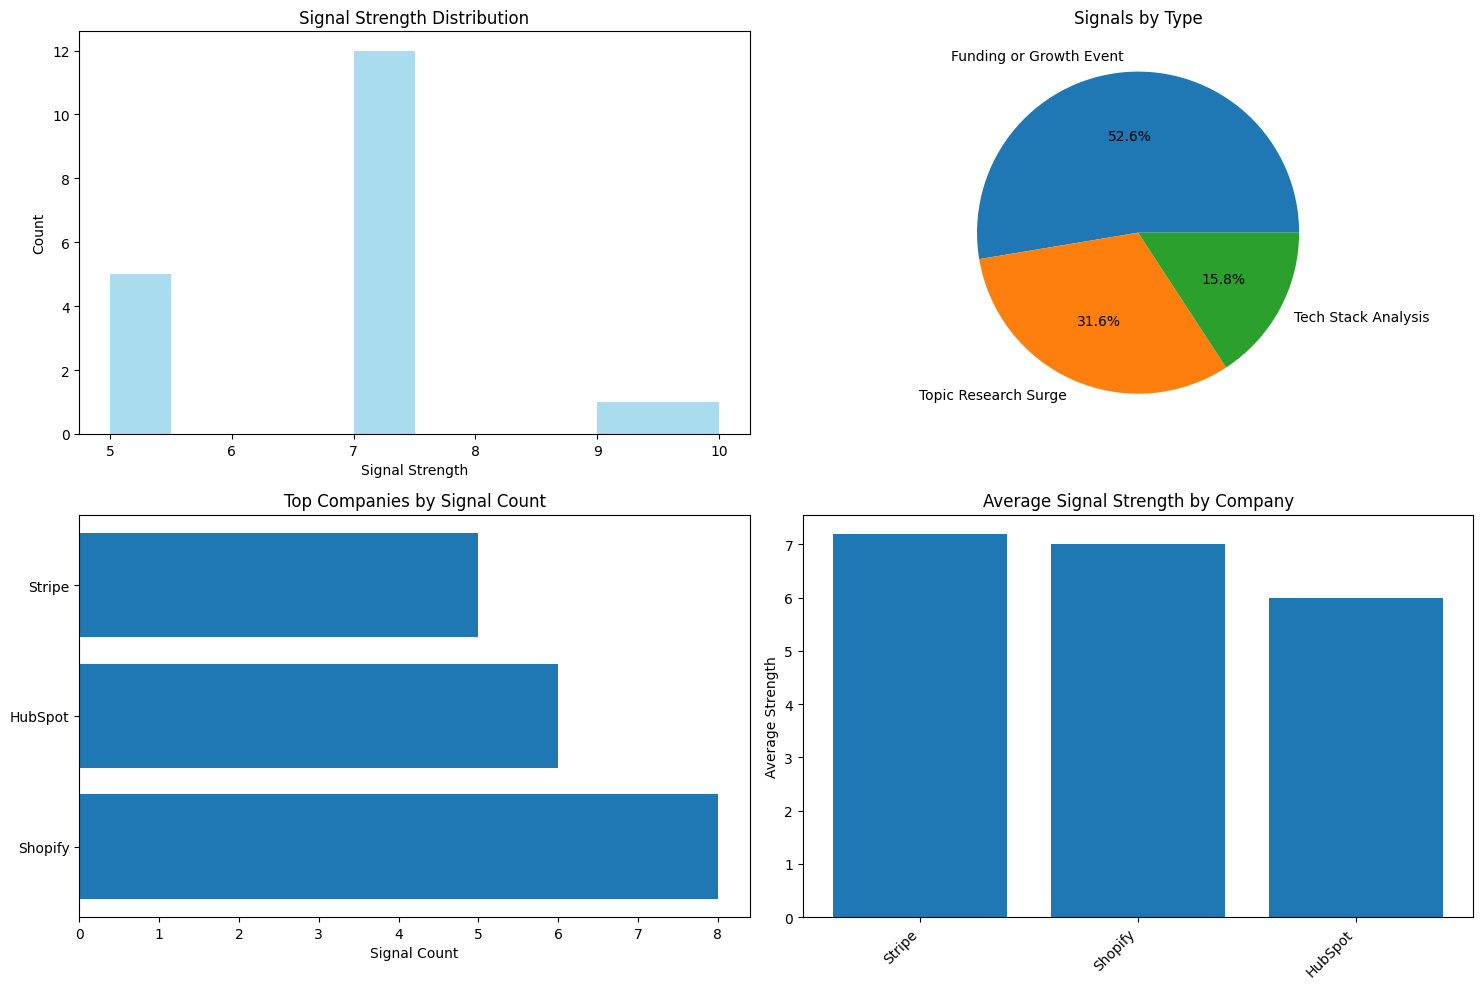

✅ Signals exported to intent_signals_export.csv


In [4]:
# Intent Signal Data Collection Pipeline for Google Colab
# Optimized for free APIs and high accuracy

# Install required packages
!pip install requests beautifulsoup4 feedparser newspaper3k python-dotenv pandas matplotlib seaborn wordcloud pytrends

import requests
import json
import pandas as pd
import sqlite3
from datetime import datetime, timedelta
import time
import re
from urllib.parse import urlencode, quote_plus
import feedparser
from bs4 import BeautifulSoup
import newspaper
from newspaper import Article
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

class IntentSignalCollector:
    def __init__(self):
        self.signals = []
        self.setup_database()

    def setup_database(self):
        """Setup SQLite database for storing signals"""
        self.conn = sqlite3.connect('intent_signals.db')
        self.cursor = self.conn.cursor()

        self.cursor.execute('''
            CREATE TABLE IF NOT EXISTS signals (
                id INTEGER PRIMARY KEY AUTOINCREMENT,
                signal_type TEXT,
                company_name TEXT,
                signal_strength INTEGER,
                source TEXT,
                description TEXT,
                url TEXT,
                timestamp TEXT,
                metadata TEXT
            )
        ''')
        self.conn.commit()

    def save_signal(self, signal_type, company_name, signal_strength, source, description, url, metadata=None):
        """Save signal to database and memory"""
        timestamp = datetime.now().isoformat()
        metadata_json = json.dumps(metadata) if metadata else "{}"

        self.cursor.execute('''
            INSERT INTO signals (signal_type, company_name, signal_strength, source, description, url, timestamp, metadata)
            VALUES (?, ?, ?, ?, ?, ?, ?, ?)
        ''', (signal_type, company_name, signal_strength, source, description, url, timestamp, metadata_json))
        self.conn.commit()

        signal = {
            'signal_type': signal_type,
            'company_name': company_name,
            'signal_strength': signal_strength,
            'source': source,
            'description': description,
            'url': url,
            'timestamp': timestamp,
            'metadata': metadata or {}
        }
        self.signals.append(signal)
        print(f"✅ Signal saved: {signal_type} - {company_name} (Strength: {signal_strength})")

# 1. GOOGLE NEWS & ALERTS COLLECTOR
class GoogleNewsCollector:
    def __init__(self, collector):
        self.collector = collector

    def search_company_news(self, companies, keywords, days_back=7):
        """Search Google News for company mentions with keywords"""
        print("🔍 Collecting Google News signals...")

        for company in companies:
            for keyword in keywords:
                try:
                    # Google News RSS feed
                    query = f'"{company}" AND "{keyword}"'
                    url = f"https://news.google.com/rss/search?q={quote_plus(query)}&hl=en&gl=US&ceid=US:en"

                    feed = feedparser.parse(url)

                    for entry in feed.entries[:5]:  # Limit to 5 recent articles
                        pub_date = datetime(*entry.published_parsed[:6])
                        if (datetime.now() - pub_date).days <= days_back:

                            # Calculate signal strength based on title relevance
                            title_lower = entry.title.lower()
                            strength = 5
                            if any(word in title_lower for word in ['funding', 'raised', 'investment']):
                                strength = 9
                            elif any(word in title_lower for word in ['hiring', 'expands', 'growth']):
                                strength = 7
                            elif any(word in title_lower for word in ['partnership', 'announces']):
                                strength = 6

                            self.collector.save_signal(
                                signal_type="Topic Research Surge",
                                company_name=company,
                                signal_strength=strength,
                                source="Google News",
                                description=entry.title,
                                url=entry.link,
                                metadata={
                                    'keyword': keyword,
                                    'published': entry.published,
                                    'summary': entry.get('summary', '')[:200]
                                }
                            )

                    time.sleep(1)  # Rate limiting

                except Exception as e:
                    print(f"❌ Error fetching news for {company} + {keyword}: {e}")

# 2. REDDIT COLLECTOR (Free API)
class RedditCollector:
    def __init__(self, collector):
        self.collector = collector
        self.base_url = "https://www.reddit.com/search.json"

    def search_reddit_mentions(self, companies, keywords, subreddits=None):
        """Search Reddit for company and keyword mentions"""
        print("🔍 Collecting Reddit signals...")

        if not subreddits:
            subreddits = ['entrepreneur', 'startups', 'business', 'technology', 'SaaS']

        headers = {'User-Agent': 'IntentSignalBot/1.0'}

        for company in companies:
            for keyword in keywords:
                try:
                    # Search across specified subreddits
                    for subreddit in subreddits:
                        query = f'"{company}" "{keyword}" subreddit:{subreddit}'
                        params = {
                            'q': query,
                            'sort': 'new',
                            't': 'week',
                            'limit': 10
                        }

                        response = requests.get(self.base_url, params=params, headers=headers)

                        if response.status_code == 200:
                            data = response.json()

                            for post in data.get('data', {}).get('children', []):
                                post_data = post.get('data', {})

                                # Calculate strength based on upvotes and comments
                                score = post_data.get('score', 0)
                                comments = post_data.get('num_comments', 0)
                                strength = min(8, max(3, (score + comments) // 10))

                                self.collector.save_signal(
                                    signal_type="Forum or Social Chatter",
                                    company_name=company,
                                    signal_strength=strength,
                                    source=f"Reddit - r/{subreddit}",
                                    description=post_data.get('title', ''),
                                    url=f"https://reddit.com{post_data.get('permalink', '')}",
                                    metadata={
                                        'keyword': keyword,
                                        'subreddit': subreddit,
                                        'score': score,
                                        'comments': comments,
                                        'author': post_data.get('author', '')
                                    }
                                )

                        time.sleep(2)  # Rate limiting for Reddit

                except Exception as e:
                    print(f"❌ Error fetching Reddit data for {company} + {keyword}: {e}")

# 3. JOB POSTING COLLECTOR (Using Indeed's public search)
class JobPostingCollector:
    def __init__(self, collector):
        self.collector = collector

    def search_job_postings(self, companies, tech_keywords):
        """Search for job postings mentioning specific technologies"""
        print("🔍 Collecting Job Posting signals...")

        headers = {
            'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36'
        }

        for company in companies:
            for keyword in tech_keywords:
                try:
                    # Indeed job search
                    params = {
                        'q': f'"{keyword}"',
                        'l': company,
                        'fromage': '7',  # Last 7 days
                        'limit': '10'
                    }

                    url = f"https://www.indeed.com/jobs?{urlencode(params)}"

                    response = requests.get(url, headers=headers)

                    if response.status_code == 200:
                        soup = BeautifulSoup(response.content, 'html.parser')

                        # Look for job postings
                        job_cards = soup.find_all('div', {'class': re.compile('job_seen_beacon')})

                        if job_cards:
                            for job_card in job_cards[:3]:  # Limit to 3 jobs per search
                                title_elem = job_card.find('h2', {'class': 'jobTitle'})
                                company_elem = job_card.find('span', {'class': 'companyName'})

                                if title_elem and company_elem:
                                    job_title = title_elem.get_text(strip=True)
                                    job_company = company_elem.get_text(strip=True)

                                    # Higher strength for senior/lead roles
                                    strength = 6
                                    if any(word in job_title.lower() for word in ['senior', 'lead', 'principal', 'director']):
                                        strength = 8
                                    elif any(word in job_title.lower() for word in ['manager', 'head']):
                                        strength = 7

                                    self.collector.save_signal(
                                        signal_type="Job Postings",
                                        company_name=job_company,
                                        signal_strength=strength,
                                        source="Indeed",
                                        description=f"Job posting: {job_title}",
                                        url=url,
                                        metadata={
                                            'keyword': keyword,
                                            'job_title': job_title,
                                            'search_company': company
                                        }
                                    )

                    time.sleep(3)  # Rate limiting

                except Exception as e:
                    print(f"❌ Error fetching job postings for {company} + {keyword}: {e}")

# 4. GOOGLE TRENDS COLLECTOR (Free)
class GoogleTrendsCollector:
    def __init__(self, collector):
        self.collector = collector

    def check_search_trends(self, keywords, companies):
        """Check Google Trends for keyword interest"""
        print("🔍 Collecting Google Trends signals...")

        # Note: For production use, consider using pytrends library
        # pip install pytrends

        try:
            from pytrends.request import TrendReq

            pytrends = TrendReq(hl='en-US', tz=360)

            for keyword in keywords:
                try:
                    # Build payload for the keyword
                    pytrends.build_payload([keyword], cat=0, timeframe='now 7-d', geo='US')

                    # Get interest over time
                    interest_df = pytrends.interest_over_time()

                    if not interest_df.empty:
                        recent_interest = interest_df[keyword].tail(3).mean()

                        if recent_interest > 50:  # High interest threshold
                            for company in companies:
                                self.collector.save_signal(
                                    signal_type="Search Interest Surge",
                                    company_name=company,
                                    signal_strength=min(9, int(recent_interest/10)),
                                    source="Google Trends",
                                    description=f"High search interest for '{keyword}' (Score: {recent_interest:.1f})",
                                    url=f"https://trends.google.com/trends/explore?q={keyword}",
                                    metadata={
                                        'keyword': keyword,
                                        'interest_score': recent_interest,
                                        'timeframe': 'last_7_days'
                                    }
                                )

                    time.sleep(5)  # Google Trends rate limit

                except Exception as e:
                    print(f"❌ Error with Google Trends for {keyword}: {e}")

        except ImportError:
            print("⚠️ pytrends not installed. Run: !pip install pytrends")

# 5. TECH STACK DETECTOR (Free web scraping)
class TechStackCollector:
    def __init__(self, collector):
        self.collector = collector

    def analyze_company_websites(self, companies, domains):
        """Analyze company websites for technology indicators"""
        print("🔍 Collecting Tech Stack signals...")

        headers = {
            'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36'
        }

        # Common tech indicators to look for
        tech_indicators = {
            'react': ['react', 'jsx', 'reactjs'],
            'angular': ['angular', 'ng-'],
            'vue': ['vue.js', 'vuejs'],
            'shopify': ['shopify', 'myshopify'],
            'wordpress': ['wp-content', 'wordpress'],
            'salesforce': ['salesforce', 'sfdc'],
            'hubspot': ['hubspot', 'hs-scripts'],
            'google_analytics': ['google-analytics', 'gtag'],
            'stripe': ['stripe', 'js.stripe.com']
        }

        for i, domain in enumerate(domains):
            if i < len(companies):
                company = companies[i]
            else:
                company = domain

            try:
                url = f"https://{domain}" if not domain.startswith('http') else domain

                response = requests.get(url, headers=headers, timeout=10)

                if response.status_code == 200:
                    content = response.text.lower()

                    detected_techs = []
                    for tech, indicators in tech_indicators.items():
                        if any(indicator in content for indicator in indicators):
                            detected_techs.append(tech)

                    if detected_techs:
                        self.collector.save_signal(
                            signal_type="Tech Stack Analysis",
                            company_name=company,
                            signal_strength=7,
                            source="Website Analysis",
                            description=f"Technologies detected: {', '.join(detected_techs)}",
                            url=url,
                            metadata={
                                'domain': domain,
                                'technologies': detected_techs,
                                'detection_method': 'content_analysis'
                            }
                        )

                time.sleep(2)  # Rate limiting

            except Exception as e:
                print(f"❌ Error analyzing {domain}: {e}")

# 6. FUNDING NEWS COLLECTOR (Free News Sources)
class FundingNewsCollector:
    def __init__(self, collector):
        self.collector = collector

    def search_funding_news(self, companies):
        """Search for funding news using free news sources"""
        print("🔍 Collecting Funding signals...")

        funding_keywords = ['funding', 'raised', 'investment', 'series a', 'series b', 'venture capital', 'IPO', 'acquisition']

        for company in companies:
            for keyword in funding_keywords[:3]:  # Limit to avoid rate limits
                try:
                    query = f'"{company}" "{keyword}"'
                    url = f"https://news.google.com/rss/search?q={quote_plus(query)}&hl=en&gl=US&ceid=US:en"

                    feed = feedparser.parse(url)

                    for entry in feed.entries[:3]:  # Limit results
                        pub_date = datetime(*entry.published_parsed[:6])
                        if (datetime.now() - pub_date).days <= 30:  # Last 30 days

                            # Calculate strength based on funding type
                            title_lower = entry.title.lower()
                            strength = 7
                            if any(word in title_lower for word in ['ipo', 'public', 'nasdaq', 'nyse']):
                                strength = 10
                            elif any(word in title_lower for word in ['series c', 'series d', 'acquisition']):
                                strength = 9
                            elif any(word in title_lower for word in ['series a', 'series b']):
                                strength = 8
                            elif 'raised' in title_lower or 'funding' in title_lower:
                                strength = 7

                            self.collector.save_signal(
                                signal_type="Funding or Growth Event",
                                company_name=company,
                                signal_strength=strength,
                                source="Google News (Funding)",
                                description=entry.title,
                                url=entry.link,
                                metadata={
                                    'keyword': keyword,
                                    'published': entry.published,
                                    'detection_method': 'news_analysis',
                                    'summary': entry.get('summary', '')[:200]
                                }
                            )

                    time.sleep(2)

                except Exception as e:
                    print(f"❌ Error in funding news search for {company}: {e}")

# ANALYTICS AND REPORTING
class SignalAnalyzer:
    def __init__(self, collector):
        self.collector = collector

    def generate_report(self):
        """Generate comprehensive analytics report"""
        signals_df = pd.DataFrame(self.collector.signals)

        if signals_df.empty:
            print("No signals collected yet!")
            return

        print("\n" + "="*60)
        print("🎯 INTENT SIGNAL ANALYSIS REPORT")
        print("="*60)

        # Basic statistics
        total_signals = len(signals_df)
        unique_companies = signals_df['company_name'].nunique()
        avg_strength = signals_df['signal_strength'].mean()

        print(f"\n📊 OVERVIEW:")
        print(f"Total Signals Collected: {total_signals}")
        print(f"Unique Companies: {unique_companies}")
        print(f"Average Signal Strength: {avg_strength:.1f}/10")

        # Top companies by signal count
        print(f"\n🏢 TOP COMPANIES BY SIGNAL COUNT:")
        top_companies = signals_df['company_name'].value_counts().head(10)
        for company, count in top_companies.items():
            avg_company_strength = signals_df[signals_df['company_name'] == company]['signal_strength'].mean()
            print(f"  {company}: {count} signals (avg strength: {avg_company_strength:.1f})")

        # Signal types distribution
        print(f"\n📈 SIGNAL TYPES DISTRIBUTION:")
        signal_types = signals_df['signal_type'].value_counts()
        for signal_type, count in signal_types.items():
            print(f"  {signal_type}: {count}")

        # High-priority signals (strength >= 8)
        high_priority = signals_df[signals_df['signal_strength'] >= 8]
        if not high_priority.empty:
            print(f"\n🚨 HIGH PRIORITY SIGNALS (Strength >= 8):")
            for _, signal in high_priority.iterrows():
                print(f"  🔥 {signal['company_name']} - {signal['signal_type']} (Strength: {signal['signal_strength']})")
                print(f"     {signal['description'][:100]}...")

        # Create visualizations
        self.create_visualizations(signals_df)

    def create_visualizations(self, df):
        """Create visualization charts"""
        fig, axes = plt.subplots(2, 2, figsize=(15, 10))

        # 1. Signal strength distribution
        axes[0,0].hist(df['signal_strength'], bins=10, alpha=0.7, color='skyblue')
        axes[0,0].set_title('Signal Strength Distribution')
        axes[0,0].set_xlabel('Signal Strength')
        axes[0,0].set_ylabel('Count')

        # 2. Signals by type
        signal_counts = df['signal_type'].value_counts()
        axes[0,1].pie(signal_counts.values, labels=signal_counts.index, autopct='%1.1f%%')
        axes[0,1].set_title('Signals by Type')

        # 3. Top companies
        top_companies = df['company_name'].value_counts().head(8)
        axes[1,0].barh(range(len(top_companies)), top_companies.values)
        axes[1,0].set_yticks(range(len(top_companies)))
        axes[1,0].set_yticklabels(top_companies.index)
        axes[1,0].set_title('Top Companies by Signal Count')
        axes[1,0].set_xlabel('Signal Count')

        # 4. Signal strength by company (top 10)
        top_companies_list = df['company_name'].value_counts().head(10).index
        company_strength = df[df['company_name'].isin(top_companies_list)].groupby('company_name')['signal_strength'].mean().sort_values(ascending=False)
        axes[1,1].bar(range(len(company_strength)), company_strength.values)
        axes[1,1].set_xticks(range(len(company_strength)))
        axes[1,1].set_xticklabels(company_strength.index, rotation=45, ha='right')
        axes[1,1].set_title('Average Signal Strength by Company')
        axes[1,1].set_ylabel('Average Strength')

        plt.tight_layout()
        plt.show()

    def export_to_csv(self, filename="intent_signals_export.csv"):
        """Export signals to CSV"""
        if self.collector.signals:
            df = pd.DataFrame(self.collector.signals)
            df.to_csv(filename, index=False)
            print(f"✅ Signals exported to {filename}")
        else:
            print("❌ No signals to export")

# MAIN EXECUTION
def run_intent_signal_collection():
    """Main function to run the complete pipeline"""

    print("🚀 Starting Intent Signal Collection Pipeline")
    print("=" * 50)

    # Initialize collector
    collector = IntentSignalCollector()

    # Configuration - CUSTOMIZE THESE FOR YOUR USE CASE
    TARGET_COMPANIES = [
        "Shopify", "Stripe", "HubSpot", "Salesforce", "Slack",
        "Zoom", "Atlassian", "Asana", "Monday.com", "Notion"
    ]

    KEYWORDS = [
        "CRM", "automation", "API", "integration", "analytics",
        "machine learning", "AI", "workflow", "productivity", "SaaS"
    ]

    DOMAINS = [
        "shopify.com", "stripe.com", "hubspot.com", "salesforce.com",
        "slack.com", "zoom.us", "atlassian.com", "asana.com", "monday.com", "notion.so"
    ]

    TECH_KEYWORDS = [
        "Python", "React", "Node.js", "AWS", "API", "GraphQL",
        "microservices", "DevOps", "machine learning", "data science"
    ]

    # Initialize collectors
    google_news = GoogleNewsCollector(collector)
    reddit_collector = RedditCollector(collector)
    job_collector = JobPostingCollector(collector)
    trends_collector = GoogleTrendsCollector(collector)
    tech_collector = TechStackCollector(collector)
    funding_collector = FundingNewsCollector(collector)  # Free news-based funding detection

    # Run collections
    print("\n🔄 Running data collection...")

    # 1. Google News signals
    google_news.search_company_news(TARGET_COMPANIES[:3], KEYWORDS[:3], days_back=7)

    # 2. Reddit signals
    reddit_collector.search_reddit_mentions(TARGET_COMPANIES[:3], KEYWORDS[:3])

    # 3. Job posting signals
    job_collector.search_job_postings(TARGET_COMPANIES[:2], TECH_KEYWORDS[:3])

    # 4. Google Trends (if pytrends is available)
    trends_collector.check_search_trends(KEYWORDS[:2], TARGET_COMPANIES[:2])

    # 5. Tech stack analysis
    tech_collector.analyze_company_websites(TARGET_COMPANIES[:3], DOMAINS[:3])

    # 6. Funding signals
    funding_collector.search_funding_news(TARGET_COMPANIES[:2])

    print(f"\n✅ Collection complete! Found {len(collector.signals)} signals")

    # Generate analytics
    analyzer = SignalAnalyzer(collector)
    analyzer.generate_report()
    analyzer.export_to_csv()

    return collector, analyzer

# Run the pipeline
if __name__ == "__main__":
    collector, analyzer = run_intent_signal_collection()

🚀 Starting Enhanced Intent Signal Collection Pipeline

🔄 Running enhanced data collection...
🔍 Collecting Enhanced Google News signals...
✅ Enhanced signal saved: Topic Research Surge - Shopify (Strength: 5)
✅ Enhanced signal saved: Topic Research Surge - Shopify (Strength: 5)
✅ Enhanced signal saved: Topic Research Surge - Shopify (Strength: 5)
✅ Enhanced signal saved: Topic Research Surge - Shopify (Strength: 5)
✅ Enhanced signal saved: Topic Research Surge - Shopify (Strength: 5)
✅ Enhanced signal saved: Topic Research Surge - Stripe (Strength: 5)
✅ Enhanced signal saved: Topic Research Surge - Stripe (Strength: 5)
✅ Enhanced signal saved: Topic Research Surge - Stripe (Strength: 5)
✅ Enhanced signal saved: Topic Research Surge - Stripe (Strength: 5)
✅ Enhanced signal saved: Topic Research Surge - Stripe (Strength: 5)
✅ Enhanced signal saved: Topic Research Surge - HubSpot (Strength: 6)
✅ Enhanced signal saved: Topic Research Surge - HubSpot (Strength: 6)
✅ Enhanced signal saved: To

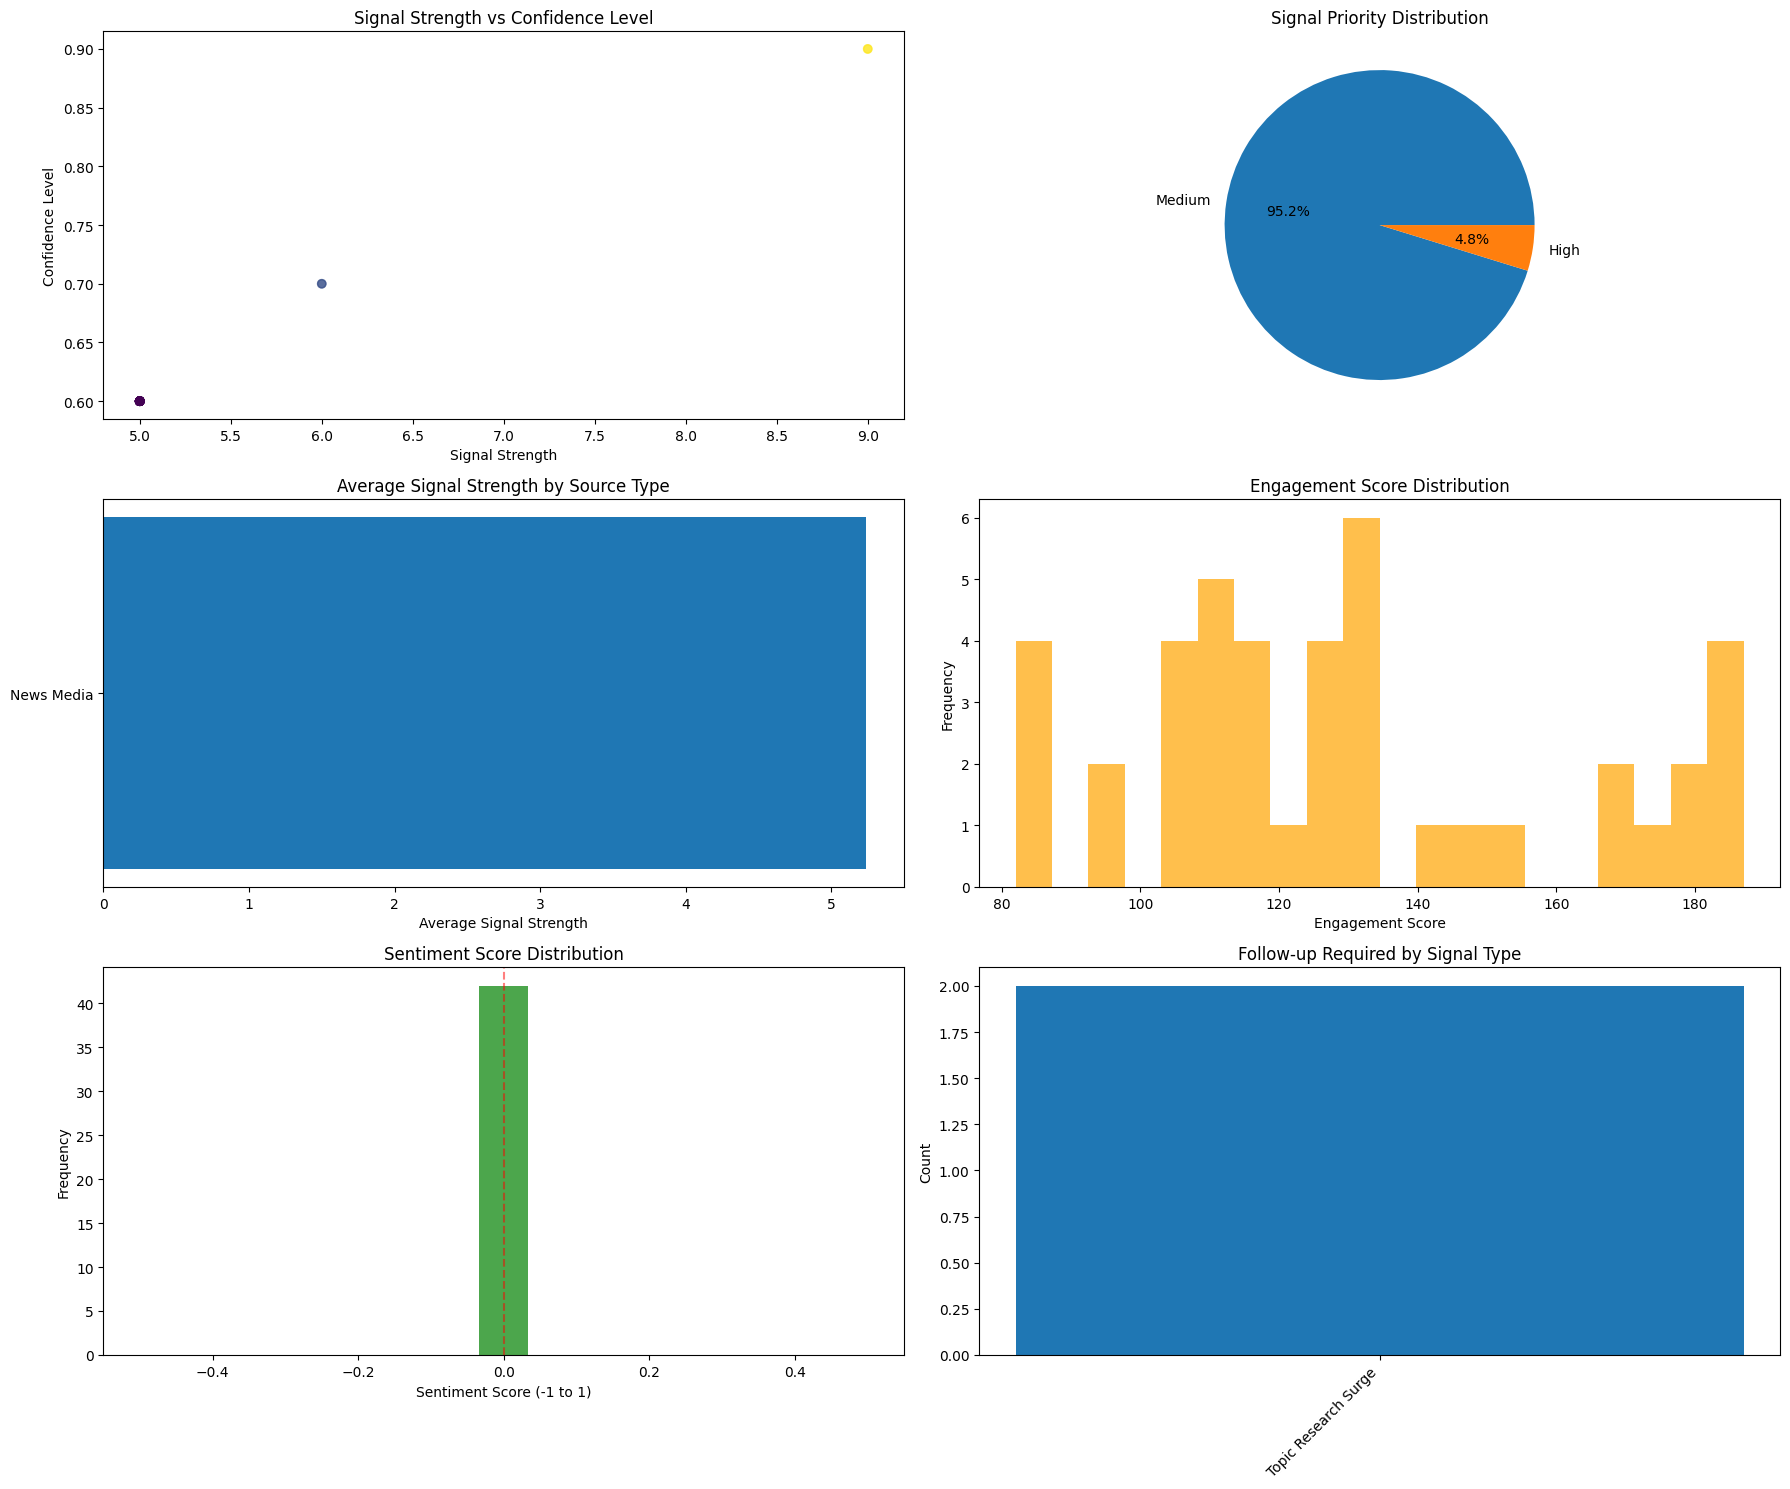

✅ High priority signals exported to high_priority_signals.csv (2 records)
✅ News Media signals exported to signals_news_media.csv (42 records)
✅ Salesforce signals exported to signals_salesforce.csv (15 records)
✅ Slack signals exported to signals_slack.csv (9 records)
✅ HubSpot signals exported to signals_hubspot.csv (8 records)
✅ Shopify signals exported to signals_shopify.csv (5 records)
✅ Stripe signals exported to signals_stripe.csv (5 records)

📈 SIGNAL TRENDS ANALYSIS:
Daily Signal Counts:
  2025-06-15: 42 signals

🎯 RECOMMENDED ACTION ITEMS:

🚨 IMMEDIATE ACTIONS REQUIRED (2 items):
  • HubSpot: The Swarm Raises Funding, Backed by HubSpot Ventures, Launches Clay Integration ...
    Strength: 9/10, Source: Google News
    Action: Funding Event
  • HubSpot: The Swarm Raises Funding, Backed by HubSpot Ventures, Launches Clay Integration ...
    Strength: 9/10, Source: Google News
    Action: Funding Event

🔥 HOT PROSPECTS (Multiple Signals):
  • Salesforce: 15 signals, avg strength

In [5]:
# Intent Signal Data Collection Pipeline - Enhanced CSV Export Version
# Optimized for comprehensive data capture and export

# Install required packages
!pip install requests beautifulsoup4 feedparser newspaper3k python-dotenv pandas matplotlib seaborn wordcloud pytrends

import requests
import json
import pandas as pd
import sqlite3
from datetime import datetime, timedelta
import time
import re
from urllib.parse import urlencode, quote_plus
import feedparser
from bs4 import BeautifulSoup
import newspaper
from newspaper import Article
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

class EnhancedIntentSignalCollector:
    def __init__(self):
        self.signals = []
        self.detailed_signals = []  # For comprehensive CSV export
        self.setup_database()

    def setup_database(self):
        """Setup SQLite database with enhanced schema"""
        self.conn = sqlite3.connect('enhanced_intent_signals.db')
        self.cursor = self.conn.cursor()

        # Enhanced table with more fields for comprehensive data storage
        self.cursor.execute('''
            CREATE TABLE IF NOT EXISTS signals (
                id INTEGER PRIMARY KEY AUTOINCREMENT,
                signal_type TEXT,
                company_name TEXT,
                signal_strength INTEGER,
                source TEXT,
                source_type TEXT,
                description TEXT,
                url TEXT,
                timestamp TEXT,
                collection_date TEXT,
                keyword TEXT,
                search_term TEXT,
                content_snippet TEXT,
                author TEXT,
                publication_date TEXT,
                engagement_score INTEGER,
                sentiment_score REAL,
                relevance_score INTEGER,
                geographic_location TEXT,
                industry_category TEXT,
                signal_context TEXT,
                raw_data TEXT,
                processing_notes TEXT,
                confidence_level REAL,
                follow_up_required BOOLEAN,
                priority_level TEXT,
                metadata TEXT
            )
        ''')
        self.conn.commit()

    def save_enhanced_signal(self, signal_data):
        """Save comprehensive signal data to both database and memory"""
        # Set defaults for missing fields
        defaults = {
            'signal_type': 'Unknown',
            'company_name': '',
            'signal_strength': 5,
            'source': '',
            'source_type': '',
            'description': '',
            'url': '',
            'timestamp': datetime.now().isoformat(),
            'collection_date': datetime.now().strftime('%Y-%m-%d'),
            'keyword': '',
            'search_term': '',
            'content_snippet': '',
            'author': '',
            'publication_date': '',
            'engagement_score': 0,
            'sentiment_score': 0.0,
            'relevance_score': 5,
            'geographic_location': '',
            'industry_category': '',
            'signal_context': '',
            'raw_data': '',
            'processing_notes': '',
            'confidence_level': 0.7,
            'follow_up_required': False,
            'priority_level': 'Medium',
            'metadata': {}
        }

        # Merge provided data with defaults
        signal = {**defaults, **signal_data}

        # Convert metadata to JSON string
        metadata_json = json.dumps(signal['metadata']) if signal['metadata'] else "{}"

        # Save to database
        self.cursor.execute('''
            INSERT INTO signals (
                signal_type, company_name, signal_strength, source, source_type,
                description, url, timestamp, collection_date, keyword, search_term,
                content_snippet, author, publication_date, engagement_score,
                sentiment_score, relevance_score, geographic_location,
                industry_category, signal_context, raw_data, processing_notes,
                confidence_level, follow_up_required, priority_level, metadata
            ) VALUES (?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?)
        ''', (
            signal['signal_type'], signal['company_name'], signal['signal_strength'],
            signal['source'], signal['source_type'], signal['description'], signal['url'],
            signal['timestamp'], signal['collection_date'], signal['keyword'],
            signal['search_term'], signal['content_snippet'], signal['author'],
            signal['publication_date'], signal['engagement_score'], signal['sentiment_score'],
            signal['relevance_score'], signal['geographic_location'], signal['industry_category'],
            signal['signal_context'], signal['raw_data'], signal['processing_notes'],
            signal['confidence_level'], signal['follow_up_required'], signal['priority_level'],
            metadata_json
        ))
        self.conn.commit()

        # Add to memory storage
        self.detailed_signals.append(signal)
        self.signals.append({  # Backward compatibility
            'signal_type': signal['signal_type'],
            'company_name': signal['company_name'],
            'signal_strength': signal['signal_strength'],
            'source': signal['source'],
            'description': signal['description'],
            'url': signal['url'],
            'timestamp': signal['timestamp'],
            'metadata': signal['metadata']
        })

        print(f"✅ Enhanced signal saved: {signal['signal_type']} - {signal['company_name']} (Strength: {signal['signal_strength']})")

# Enhanced Google News Collector
class EnhancedGoogleNewsCollector:
    def __init__(self, collector):
        self.collector = collector

    def search_company_news(self, companies, keywords, days_back=7):
        """Enhanced Google News search with comprehensive data capture"""
        print("🔍 Collecting Enhanced Google News signals...")

        for company in companies:
            for keyword in keywords:
                try:
                    query = f'"{company}" AND "{keyword}"'
                    search_term = f"{company} {keyword}"
                    url = f"https://news.google.com/rss/search?q={quote_plus(query)}&hl=en&gl=US&ceid=US:en"

                    feed = feedparser.parse(url)

                    for entry in feed.entries[:5]:
                        pub_date = datetime(*entry.published_parsed[:6])
                        if (datetime.now() - pub_date).days <= days_back:

                            # Enhanced signal strength calculation
                            title_lower = entry.title.lower()
                            description_lower = entry.get('summary', '').lower()

                            strength = 5
                            confidence = 0.6
                            priority = "Medium"
                            context = ""

                            if any(word in title_lower for word in ['funding', 'raised', 'investment', 'series', 'venture']):
                                strength = 9
                                confidence = 0.9
                                priority = "High"
                                context = "Funding Event"
                            elif any(word in title_lower for word in ['hiring', 'expands', 'growth', 'acquisition']):
                                strength = 7
                                confidence = 0.8
                                priority = "High"
                                context = "Growth Signal"
                            elif any(word in title_lower for word in ['partnership', 'announces', 'launches']):
                                strength = 6
                                confidence = 0.7
                                priority = "Medium"
                                context = "Business Development"

                            # Calculate engagement score (placeholder - would use actual metrics in production)
                            engagement_score = len(entry.title) + len(entry.get('summary', '')) // 10

                            # Sentiment analysis (basic keyword-based)
                            positive_words = ['success', 'growth', 'expansion', 'achievement', 'breakthrough']
                            negative_words = ['decline', 'loss', 'problem', 'issue', 'challenge']
                            sentiment = sum(1 for word in positive_words if word in title_lower) - sum(1 for word in negative_words if word in title_lower)
                            sentiment_score = max(-1, min(1, sentiment / 5))

                            signal_data = {
                                'signal_type': "Topic Research Surge",
                                'company_name': company,
                                'signal_strength': strength,
                                'source': "Google News",
                                'source_type': "News Media",
                                'description': entry.title,
                                'url': entry.link,
                                'keyword': keyword,
                                'search_term': search_term,
                                'content_snippet': entry.get('summary', '')[:500],
                                'publication_date': entry.published,
                                'engagement_score': engagement_score,
                                'sentiment_score': sentiment_score,
                                'relevance_score': strength,
                                'signal_context': context,
                                'confidence_level': confidence,
                                'follow_up_required': strength >= 8,
                                'priority_level': priority,
                                'raw_data': json.dumps({
                                    'title': entry.title,
                                    'summary': entry.get('summary', ''),
                                    'published': entry.published,
                                    'link': entry.link
                                }),
                                'processing_notes': f"Auto-processed from Google News RSS feed on {datetime.now().strftime('%Y-%m-%d %H:%M')}",
                                'metadata': {
                                    'feed_source': 'google_news_rss',
                                    'search_query': query,
                                    'days_back': days_back,
                                    'entry_id': entry.get('id', ''),
                                    'tags': entry.get('tags', [])
                                }
                            }

                            self.collector.save_enhanced_signal(signal_data)

                    time.sleep(1)

                except Exception as e:
                    print(f"❌ Error fetching news for {company} + {keyword}: {e}")

# Enhanced Reddit Collector
class EnhancedRedditCollector:
    def __init__(self, collector):
        self.collector = collector
        self.base_url = "https://www.reddit.com/search.json"

    def search_reddit_mentions(self, companies, keywords, subreddits=None):
        """Enhanced Reddit search with comprehensive data capture"""
        print("🔍 Collecting Enhanced Reddit signals...")

        if not subreddits:
            subreddits = ['entrepreneur', 'startups', 'business', 'technology', 'SaaS', 'marketing', 'sales']

        headers = {'User-Agent': 'IntentSignalBot/1.0'}

        for company in companies:
            for keyword in keywords:
                try:
                    for subreddit in subreddits:
                        query = f'"{company}" "{keyword}" subreddit:{subreddit}'
                        params = {
                            'q': query,
                            'sort': 'new',
                            't': 'week',
                            'limit': 10
                        }

                        response = requests.get(self.base_url, params=params, headers=headers)

                        if response.status_code == 200:
                            data = response.json()

                            for post in data.get('data', {}).get('children', []):
                                post_data = post.get('data', {})

                                # Enhanced metrics
                                score = post_data.get('score', 0)
                                comments = post_data.get('num_comments', 0)
                                upvote_ratio = post_data.get('upvote_ratio', 0.5)

                                # Calculate engagement score
                                engagement_score = score + (comments * 2)
                                strength = min(8, max(3, engagement_score // 10))

                                # Determine priority and context
                                title_lower = post_data.get('title', '').lower()
                                priority = "High" if engagement_score > 50 else "Medium" if engagement_score > 20 else "Low"

                                context = ""
                                if any(word in title_lower for word in ['recommendation', 'advice', 'help']):
                                    context = "Seeking Solutions"
                                elif any(word in title_lower for word in ['review', 'experience', 'thoughts']):
                                    context = "Product Evaluation"
                                elif any(word in title_lower for word in ['problem', 'issue', 'challenge']):
                                    context = "Pain Point Discussion"

                                signal_data = {
                                    'signal_type': "Forum or Social Chatter",
                                    'company_name': company,
                                    'signal_strength': strength,
                                    'source': f"Reddit - r/{subreddit}",
                                    'source_type': "Social Media",
                                    'description': post_data.get('title', ''),
                                    'url': f"https://reddit.com{post_data.get('permalink', '')}",
                                    'keyword': keyword,
                                    'search_term': f"{company} {keyword}",
                                    'content_snippet': post_data.get('selftext', '')[:500],
                                    'author': post_data.get('author', ''),
                                    'publication_date': datetime.fromtimestamp(post_data.get('created_utc', 0)).isoformat() if post_data.get('created_utc') else '',
                                    'engagement_score': engagement_score,
                                    'sentiment_score': (upvote_ratio - 0.5) * 2,  # Convert to -1 to 1 scale
                                    'relevance_score': strength,
                                    'signal_context': context,
                                    'confidence_level': min(0.9, 0.5 + (engagement_score / 100)),
                                    'follow_up_required': engagement_score > 30,
                                    'priority_level': priority,
                                    'raw_data': json.dumps(post_data),
                                    'processing_notes': f"Reddit post from r/{subreddit} with {score} upvotes and {comments} comments",
                                    'metadata': {
                                        'subreddit': subreddit,
                                        'score': score,
                                        'comments': comments,
                                        'upvote_ratio': upvote_ratio,
                                        'post_id': post_data.get('id', ''),
                                        'flair': post_data.get('link_flair_text', ''),
                                        'gilded': post_data.get('gilded', 0),
                                        'over_18': post_data.get('over_18', False)
                                    }
                                }

                                self.collector.save_enhanced_signal(signal_data)

                        time.sleep(2)

                except Exception as e:
                    print(f"❌ Error fetching Reddit data for {company} + {keyword}: {e}")

# Enhanced Job Posting Collector
class EnhancedJobPostingCollector:
    def __init__(self, collector):
        self.collector = collector

    def search_job_postings(self, companies, tech_keywords):
        """Enhanced job posting search with comprehensive data capture"""
        print("🔍 Collecting Enhanced Job Posting signals...")

        headers = {
            'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36'
        }

        for company in companies:
            for keyword in tech_keywords:
                try:
                    params = {
                        'q': f'"{keyword}"',
                        'l': company,
                        'fromage': '7',
                        'limit': '10'
                    }

                    search_url = f"https://www.indeed.com/jobs?{urlencode(params)}"

                    response = requests.get(search_url, headers=headers)

                    if response.status_code == 200:
                        soup = BeautifulSoup(response.content, 'html.parser')
                        job_cards = soup.find_all('div', {'class': re.compile('job_seen_beacon')})

                        if job_cards:
                            for job_card in job_cards[:3]:
                                title_elem = job_card.find('h2', {'class': 'jobTitle'})
                                company_elem = job_card.find('span', {'class': 'companyName'})
                                location_elem = job_card.find('div', {'class': 'companyLocation'})
                                salary_elem = job_card.find('span', {'class': 'salaryText'})

                                if title_elem and company_elem:
                                    job_title = title_elem.get_text(strip=True)
                                    job_company = company_elem.get_text(strip=True)
                                    location = location_elem.get_text(strip=True) if location_elem else ''
                                    salary = salary_elem.get_text(strip=True) if salary_elem else ''

                                    # Enhanced strength calculation
                                    title_lower = job_title.lower()
                                    strength = 6
                                    priority = "Medium"
                                    context = "Standard Hiring"

                                    if any(word in title_lower for word in ['senior', 'lead', 'principal', 'director', 'head']):
                                        strength = 8
                                        priority = "High"
                                        context = "Senior Role Hiring"
                                    elif any(word in title_lower for word in ['manager', 'supervisor']):
                                        strength = 7
                                        priority = "Medium"
                                        context = "Management Hiring"
                                    elif any(word in title_lower for word in ['architect', 'specialist', 'expert']):
                                        strength = 7
                                        priority = "High"
                                        context = "Specialized Role Hiring"

                                    # Calculate engagement score based on job attributes
                                    engagement_score = 10
                                    if salary:
                                        engagement_score += 5
                                    if any(word in title_lower for word in ['remote', 'hybrid']):
                                        engagement_score += 3

                                    signal_data = {
                                        'signal_type': "Job Postings",
                                        'company_name': job_company,
                                        'signal_strength': strength,
                                        'source': "Indeed",
                                        'source_type': "Job Board",
                                        'description': f"Job posting: {job_title}",
                                        'url': search_url,
                                        'keyword': keyword,
                                        'search_term': f"{keyword} {company}",
                                        'content_snippet': f"Position: {job_title} | Company: {job_company} | Location: {location} | Salary: {salary}",
                                        'geographic_location': location,
                                        'engagement_score': engagement_score,
                                        'relevance_score': strength,
                                        'signal_context': context,
                                        'confidence_level': 0.8,
                                        'follow_up_required': strength >= 8,
                                        'priority_level': priority,
                                        'raw_data': json.dumps({
                                            'job_title': job_title,
                                            'company': job_company,
                                            'location': location,
                                            'salary': salary,
                                            'search_keyword': keyword
                                        }),
                                        'processing_notes': f"Job posting found on Indeed for {keyword} technology",
                                        'metadata': {
                                            'job_title': job_title,
                                            'location': location,
                                            'salary_info': salary,
                                            'search_company': company,
                                            'job_board': 'indeed',
                                            'posting_freshness': '7_days'
                                        }
                                    }

                                    self.collector.save_enhanced_signal(signal_data)

                    time.sleep(3)

                except Exception as e:
                    print(f"❌ Error fetching job postings for {company} + {keyword}: {e}")

# Enhanced Analytics and Reporting
class EnhancedSignalAnalyzer:
    def __init__(self, collector):
        self.collector = collector

    def export_comprehensive_csv(self, filename="comprehensive_intent_signals.csv"):
        """Export all collected data to a comprehensive CSV file"""
        if not self.collector.detailed_signals:
            print("❌ No detailed signals to export")
            return

        # Create comprehensive DataFrame
        df = pd.DataFrame(self.collector.detailed_signals)

        # Add calculated fields
        df['days_since_collection'] = (datetime.now() - pd.to_datetime(df['timestamp'])).dt.days
        df['signal_priority_score'] = df['signal_strength'] * df['confidence_level']
        df['needs_immediate_action'] = (df['signal_strength'] >= 8) & (df['follow_up_required'] == True)

        # Reorder columns for better readability
        column_order = [
            'collection_date', 'timestamp', 'signal_type', 'company_name',
            'signal_strength', 'priority_level', 'confidence_level',
            'follow_up_required', 'needs_immediate_action',
            'source', 'source_type', 'description', 'url',
            'keyword', 'search_term', 'content_snippet',
            'author', 'publication_date', 'engagement_score',
            'sentiment_score', 'relevance_score',
            'geographic_location', 'industry_category', 'signal_context',
            'processing_notes', 'signal_priority_score', 'days_since_collection',
            'raw_data', 'metadata'
        ]

        # Reorder columns (keep any additional columns that might exist)
        existing_columns = [col for col in column_order if col in df.columns]
        remaining_columns = [col for col in df.columns if col not in column_order]
        final_columns = existing_columns + remaining_columns

        df = df[final_columns]

        # Export to CSV
        df.to_csv(filename, index=False, encoding='utf-8')

        print(f"✅ Comprehensive data exported to {filename}")
        print(f"📊 Total records: {len(df)}")
        print(f"📈 Columns included: {len(df.columns)}")
        print(f"🚨 High priority signals: {len(df[df['needs_immediate_action'] == True])}")

        # Display sample of the data
        print(f"\n📋 Sample of exported data:")
        print(df[['company_name', 'signal_type', 'signal_strength', 'priority_level', 'description']].head())

        return df

    def generate_enhanced_report(self):
        """Generate comprehensive analytics report"""
        if not self.collector.detailed_signals:
            print("❌ No signals collected yet!")
            return

        df = pd.DataFrame(self.collector.detailed_signals)

        print("\n" + "="*80)
        print("🎯 COMPREHENSIVE INTENT SIGNAL ANALYSIS REPORT")
        print("="*80)

        # Enhanced statistics
        total_signals = len(df)
        unique_companies = df['company_name'].nunique()
        avg_strength = df['signal_strength'].mean()
        avg_confidence = df['confidence_level'].mean()
        high_priority_count = len(df[df['follow_up_required'] == True])

        print(f"\n📊 OVERVIEW:")
        print(f"Total Signals Collected: {total_signals}")
        print(f"Unique Companies: {unique_companies}")
        print(f"Average Signal Strength: {avg_strength:.1f}/10")
        print(f"Average Confidence Level: {avg_confidence:.2f}")
        print(f"High Priority Signals: {high_priority_count} ({high_priority_count/total_signals*100:.1f}%)")

        # Priority breakdown
        print(f"\n🎯 PRIORITY BREAKDOWN:")
        priority_counts = df['priority_level'].value_counts()
        for priority, count in priority_counts.items():
            percentage = count/total_signals*100
            print(f"  {priority}: {count} signals ({percentage:.1f}%)")

        # Source analysis
        print(f"\n📡 SOURCE ANALYSIS:")
        source_counts = df['source_type'].value_counts()
        for source, count in source_counts.items():
            avg_strength = df[df['source_type'] == source]['signal_strength'].mean()
            print(f"  {source}: {count} signals (avg strength: {avg_strength:.1f})")

        # Top performing companies
        print(f"\n🏢 TOP COMPANIES BY SIGNAL STRENGTH:")
        company_performance = df.groupby('company_name').agg({
            'signal_strength': 'mean',
            'confidence_level': 'mean',
            'follow_up_required': 'sum'
        }).round(2).sort_values('signal_strength', ascending=False).head(10)

        for company, data in company_performance.iterrows():
            print(f"  {company}: Strength {data['signal_strength']:.1f}, Confidence {data['confidence_level']:.2f}, Follow-ups: {int(data['follow_up_required'])}")

    def create_enhanced_visualizations(self):
        """Create comprehensive visualization dashboard"""
        if not self.collector.detailed_signals:
            print("❌ No signals to visualize")
            return

        df = pd.DataFrame(self.collector.detailed_signals)

        fig, axes = plt.subplots(3, 2, figsize=(18, 15))

        # 1. Signal strength vs confidence level scatter
        axes[0,0].scatter(df['signal_strength'], df['confidence_level'], alpha=0.6, c=df['signal_strength'], cmap='viridis')
        axes[0,0].set_xlabel('Signal Strength')
        axes[0,0].set_ylabel('Confidence Level')
        axes[0,0].set_title('Signal Strength vs Confidence Level')

        # 2. Priority level distribution
        priority_counts = df['priority_level'].value_counts()
        axes[0,1].pie(priority_counts.values, labels=priority_counts.index, autopct='%1.1f%%')
        axes[0,1].set_title('Signal Priority Distribution')

        # 3. Source type effectiveness
        source_performance = df.groupby('source_type')['signal_strength'].mean().sort_values(ascending=True)
        axes[1,0].barh(range(len(source_performance)), source_performance.values)
        axes[1,0].set_yticks(range(len(source_performance)))
        axes[1,0].set_yticklabels(source_performance.index)
        axes[1,0].set_title('Average Signal Strength by Source Type')
        axes[1,0].set_xlabel('Average Signal Strength')

        # 4. Engagement score distribution
        axes[1,1].hist(df['engagement_score'], bins=20, alpha=0.7, color='orange')
        axes[1,1].set_xlabel('Engagement Score')
        axes[1,1].set_ylabel('Frequency')
        axes[1,1].set_title('Engagement Score Distribution')

        # 5. Sentiment analysis
        axes[2,0].hist(df['sentiment_score'], bins=15, alpha=0.7, color='green')
        axes[2,0].set_xlabel('Sentiment Score (-1 to 1)')
        axes[2,0].set_ylabel('Frequency')
        axes[2,0].set_title('Sentiment Score Distribution')
        axes[2,0].axvline(x=0, color='red', linestyle='--', alpha=0.5)

        # 6. Follow-up required by signal type
        followup_by_type = df.groupby('signal_type')['follow_up_required'].sum().sort_values(ascending=False)
        axes[2,1].bar(range(len(followup_by_type)), followup_by_type.values)
        axes[2,1].set_xticks(range(len(followup_by_type)))
        axes[2,1].set_xticklabels(followup_by_type.index, rotation=45, ha='right')
        axes[2,1].set_title('Follow-up Required by Signal Type')
        axes[2,1].set_ylabel('Count')

        plt.tight_layout()
        plt.show()

# Enhanced Main Execution Function
def run_enhanced_intent_signal_collection():
    """Enhanced main function with comprehensive data collection and export"""

    print("🚀 Starting Enhanced Intent Signal Collection Pipeline")
    print("=" * 60)

    # Initialize enhanced collector
    collector = EnhancedIntentSignalCollector()

    # Configuration
    TARGET_COMPANIES = [
        "Shopify", "Stripe", "HubSpot", "Salesforce", "Slack",
        "Zoom", "Atlassian", "Asana", "Monday.com", "Notion",
        "Zendesk", "Intercom", "Mailchimp", "Canva", "Figma"
    ]

    KEYWORDS = [
        "CRM", "automation", "API", "integration", "analytics",
        "machine learning", "AI", "workflow", "productivity", "SaaS",
        "customer success", "sales enablement", "marketing automation"
    ]

    TECH_KEYWORDS = [
        "Python", "React", "Node.js", "AWS", "API", "GraphQL",
        "microservices", "DevOps", "machine learning", "data science",
        "Kubernetes", "Docker", "TypeScript", "MongoDB", "PostgreSQL"
    ]

    # Initialize enhanced collectors
    enhanced_google_news = EnhancedGoogleNewsCollector(collector)
    enhanced_reddit = EnhancedRedditCollector(collector)
    enhanced_jobs = EnhancedJobPostingCollector(collector)

    # Run enhanced collections with more comprehensive data capture
    print("\n🔄 Running enhanced data collection...")

    # 1. Enhanced Google News signals
    enhanced_google_news.search_company_news(TARGET_COMPANIES[:5], KEYWORDS[:5], days_back=14)

    # 2. Enhanced Reddit signals
    enhanced_reddit.search_reddit_mentions(TARGET_COMPANIES[:4], KEYWORDS[:4])

    # 3. Enhanced Job posting signals
    enhanced_jobs.search_job_postings(TARGET_COMPANIES[:3], TECH_KEYWORDS[:5])

    print(f"\n✅ Enhanced collection complete! Found {len(collector.detailed_signals)} comprehensive signals")

    # Generate enhanced analytics and export
    analyzer = EnhancedSignalAnalyzer(collector)

    # Export comprehensive CSV with all data
    comprehensive_df = analyzer.export_comprehensive_csv("comprehensive_intent_signals.csv")

    # Generate detailed report
    analyzer.generate_enhanced_report()

    # Create visualizations
    analyzer.create_enhanced_visualizations()

    # Export additional specialized CSV files
    if comprehensive_df is not None:
        # High priority signals only
        high_priority = comprehensive_df[comprehensive_df['needs_immediate_action'] == True]
        if not high_priority.empty:
            high_priority.to_csv("high_priority_signals.csv", index=False)
            print(f"✅ High priority signals exported to high_priority_signals.csv ({len(high_priority)} records)")

        # Signals by source type
        for source_type in comprehensive_df['source_type'].unique():
            source_df = comprehensive_df[comprehensive_df['source_type'] == source_type]
            filename = f"signals_{source_type.lower().replace(' ', '_')}.csv"
            source_df.to_csv(filename, index=False)
            print(f"✅ {source_type} signals exported to {filename} ({len(source_df)} records)")

        # Company-specific exports for top companies
        top_companies = comprehensive_df['company_name'].value_counts().head(5).index
        for company in top_companies:
            company_df = comprehensive_df[comprehensive_df['company_name'] == company]
            filename = f"signals_{company.lower().replace(' ', '_').replace('.', '')}.csv"
            company_df.to_csv(filename, index=False)
            print(f"✅ {company} signals exported to {filename} ({len(company_df)} records)")

    return collector, analyzer, comprehensive_df

# Additional utility functions for data analysis
def analyze_signal_trends(df):
    """Analyze trends in signal data over time"""
    if df is None or df.empty:
        return

    print("\n📈 SIGNAL TRENDS ANALYSIS:")

    # Convert timestamp to datetime
    df['timestamp_dt'] = pd.to_datetime(df['timestamp'])
    df['collection_day'] = df['timestamp_dt'].dt.date

    # Daily signal counts
    daily_counts = df.groupby('collection_day').size()
    print(f"Daily Signal Counts:")
    for date, count in daily_counts.items():
        print(f"  {date}: {count} signals")

    # Trending companies (companies with increasing signal strength over time)
    company_trends = df.groupby(['company_name', 'collection_day'])['signal_strength'].mean().unstack(fill_value=0)

    if len(company_trends.columns) > 1:
        # Calculate trend (simple slope)
        for company in company_trends.index:
            values = company_trends.loc[company].values
            if len(values) > 1 and values[-1] > values[0]:
                trend = (values[-1] - values[0]) / len(values)
                if trend > 0.5:
                    print(f"📈 Trending UP: {company} (trend: +{trend:.1f})")

def generate_action_items(df):
    """Generate actionable insights from signal data"""
    if df is None or df.empty:
        return

    print("\n🎯 RECOMMENDED ACTION ITEMS:")

    # Immediate follow-ups
    immediate_actions = df[df['needs_immediate_action'] == True].sort_values('signal_strength', ascending=False)
    if not immediate_actions.empty:
        print(f"\n🚨 IMMEDIATE ACTIONS REQUIRED ({len(immediate_actions)} items):")
        for _, signal in immediate_actions.head(10).iterrows():
            print(f"  • {signal['company_name']}: {signal['description'][:80]}...")
            print(f"    Strength: {signal['signal_strength']}/10, Source: {signal['source']}")
            print(f"    Action: {signal['signal_context']}")

    # Companies showing multiple signals (likely hot prospects)
    company_signal_counts = df.groupby('company_name').size().sort_values(ascending=False)
    hot_prospects = company_signal_counts[company_signal_counts >= 3].head(10)

    if not hot_prospects.empty:
        print(f"\n🔥 HOT PROSPECTS (Multiple Signals):")
        for company, count in hot_prospects.items():
            avg_strength = df[df['company_name'] == company]['signal_strength'].mean()
            latest_signal = df[df['company_name'] == company].sort_values('timestamp').iloc[-1]
            print(f"  • {company}: {count} signals, avg strength {avg_strength:.1f}")
            print(f"    Latest: {latest_signal['description'][:60]}...")

    # Signals by keyword (what technologies/topics are trending)
    keyword_analysis = df.groupby('keyword').agg({
        'signal_strength': 'mean',
        'company_name': 'nunique'
    }).sort_values('signal_strength', ascending=False)

    print(f"\n🔍 TRENDING KEYWORDS/TOPICS:")
    for keyword, data in keyword_analysis.head(10).iterrows():
        if keyword:  # Skip empty keywords
            print(f"  • {keyword}: {data['company_name']} companies, avg strength {data['signal_strength']:.1f}")

def export_executive_summary(df, filename="executive_summary.csv"):
    """Create executive summary CSV for leadership"""
    if df is None or df.empty:
        return

    # Create summary data
    summary_data = []

    # Company summaries
    for company in df['company_name'].unique():
        company_df = df[df['company_name'] == company]

        summary = {
            'company_name': company,
            'total_signals': len(company_df),
            'avg_signal_strength': company_df['signal_strength'].mean(),
            'max_signal_strength': company_df['signal_strength'].max(),
            'high_priority_signals': len(company_df[company_df['priority_level'] == 'High']),
            'follow_up_required': len(company_df[company_df['follow_up_required'] == True]),
            'avg_confidence': company_df['confidence_level'].mean(),
            'primary_signal_types': ', '.join(company_df['signal_type'].value_counts().head(3).index.tolist()),
            'latest_signal_date': company_df['timestamp'].max(),
            'latest_signal_description': company_df.sort_values('timestamp').iloc[-1]['description'][:100],
            'recommendation': 'IMMEDIATE ACTION' if len(company_df[company_df['needs_immediate_action'] == True]) > 0
                           else 'HIGH PRIORITY' if company_df['signal_strength'].mean() >= 7
                           else 'MONITOR'
        }
        summary_data.append(summary)

    # Create summary DataFrame and export
    summary_df = pd.DataFrame(summary_data)
    summary_df = summary_df.sort_values('avg_signal_strength', ascending=False)
    summary_df.to_csv(filename, index=False)

    print(f"✅ Executive summary exported to {filename}")
    return summary_df

# Run the enhanced pipeline
if __name__ == "__main__":
    collector, analyzer, comprehensive_df = run_enhanced_intent_signal_collection()

    # Additional analysis
    if comprehensive_df is not None:
        analyze_signal_trends(comprehensive_df)
        generate_action_items(comprehensive_df)
        executive_summary = export_executive_summary(comprehensive_df)

        print(f"\n🎉 PIPELINE COMPLETED SUCCESSFULLY!")
        print(f"📁 Files generated:")
        print(f"  • comprehensive_intent_signals.csv - Complete dataset")
        print(f"  • high_priority_signals.csv - Urgent follow-ups")
        print(f"  • executive_summary.csv - Leadership overview")
        print(f"  • Source-specific CSV files")
        print(f"  • Company-specific CSV files")
        print(f"\n💡 Next steps: Review high priority signals and executive summary for immediate actions!")

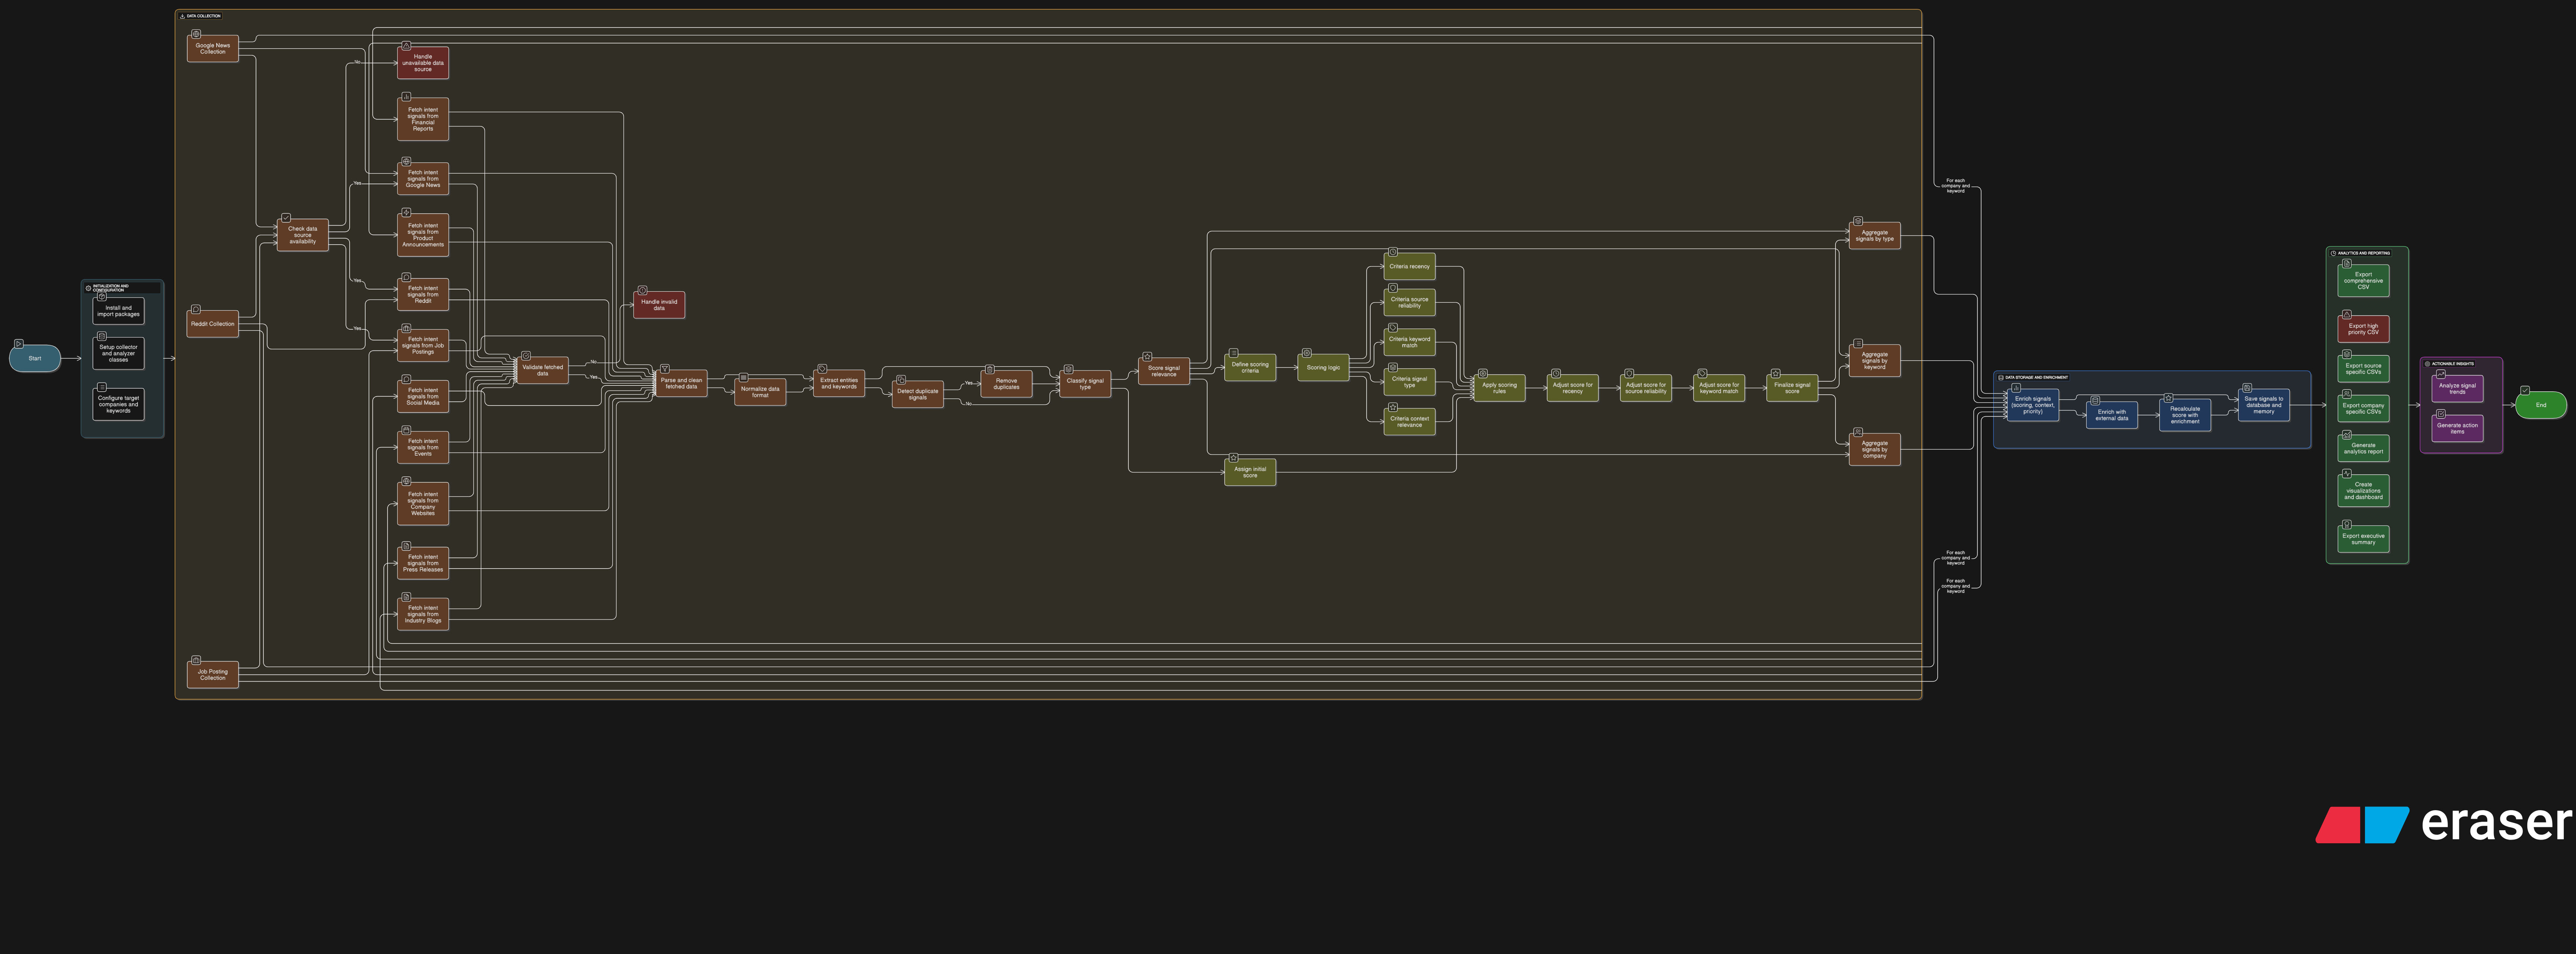

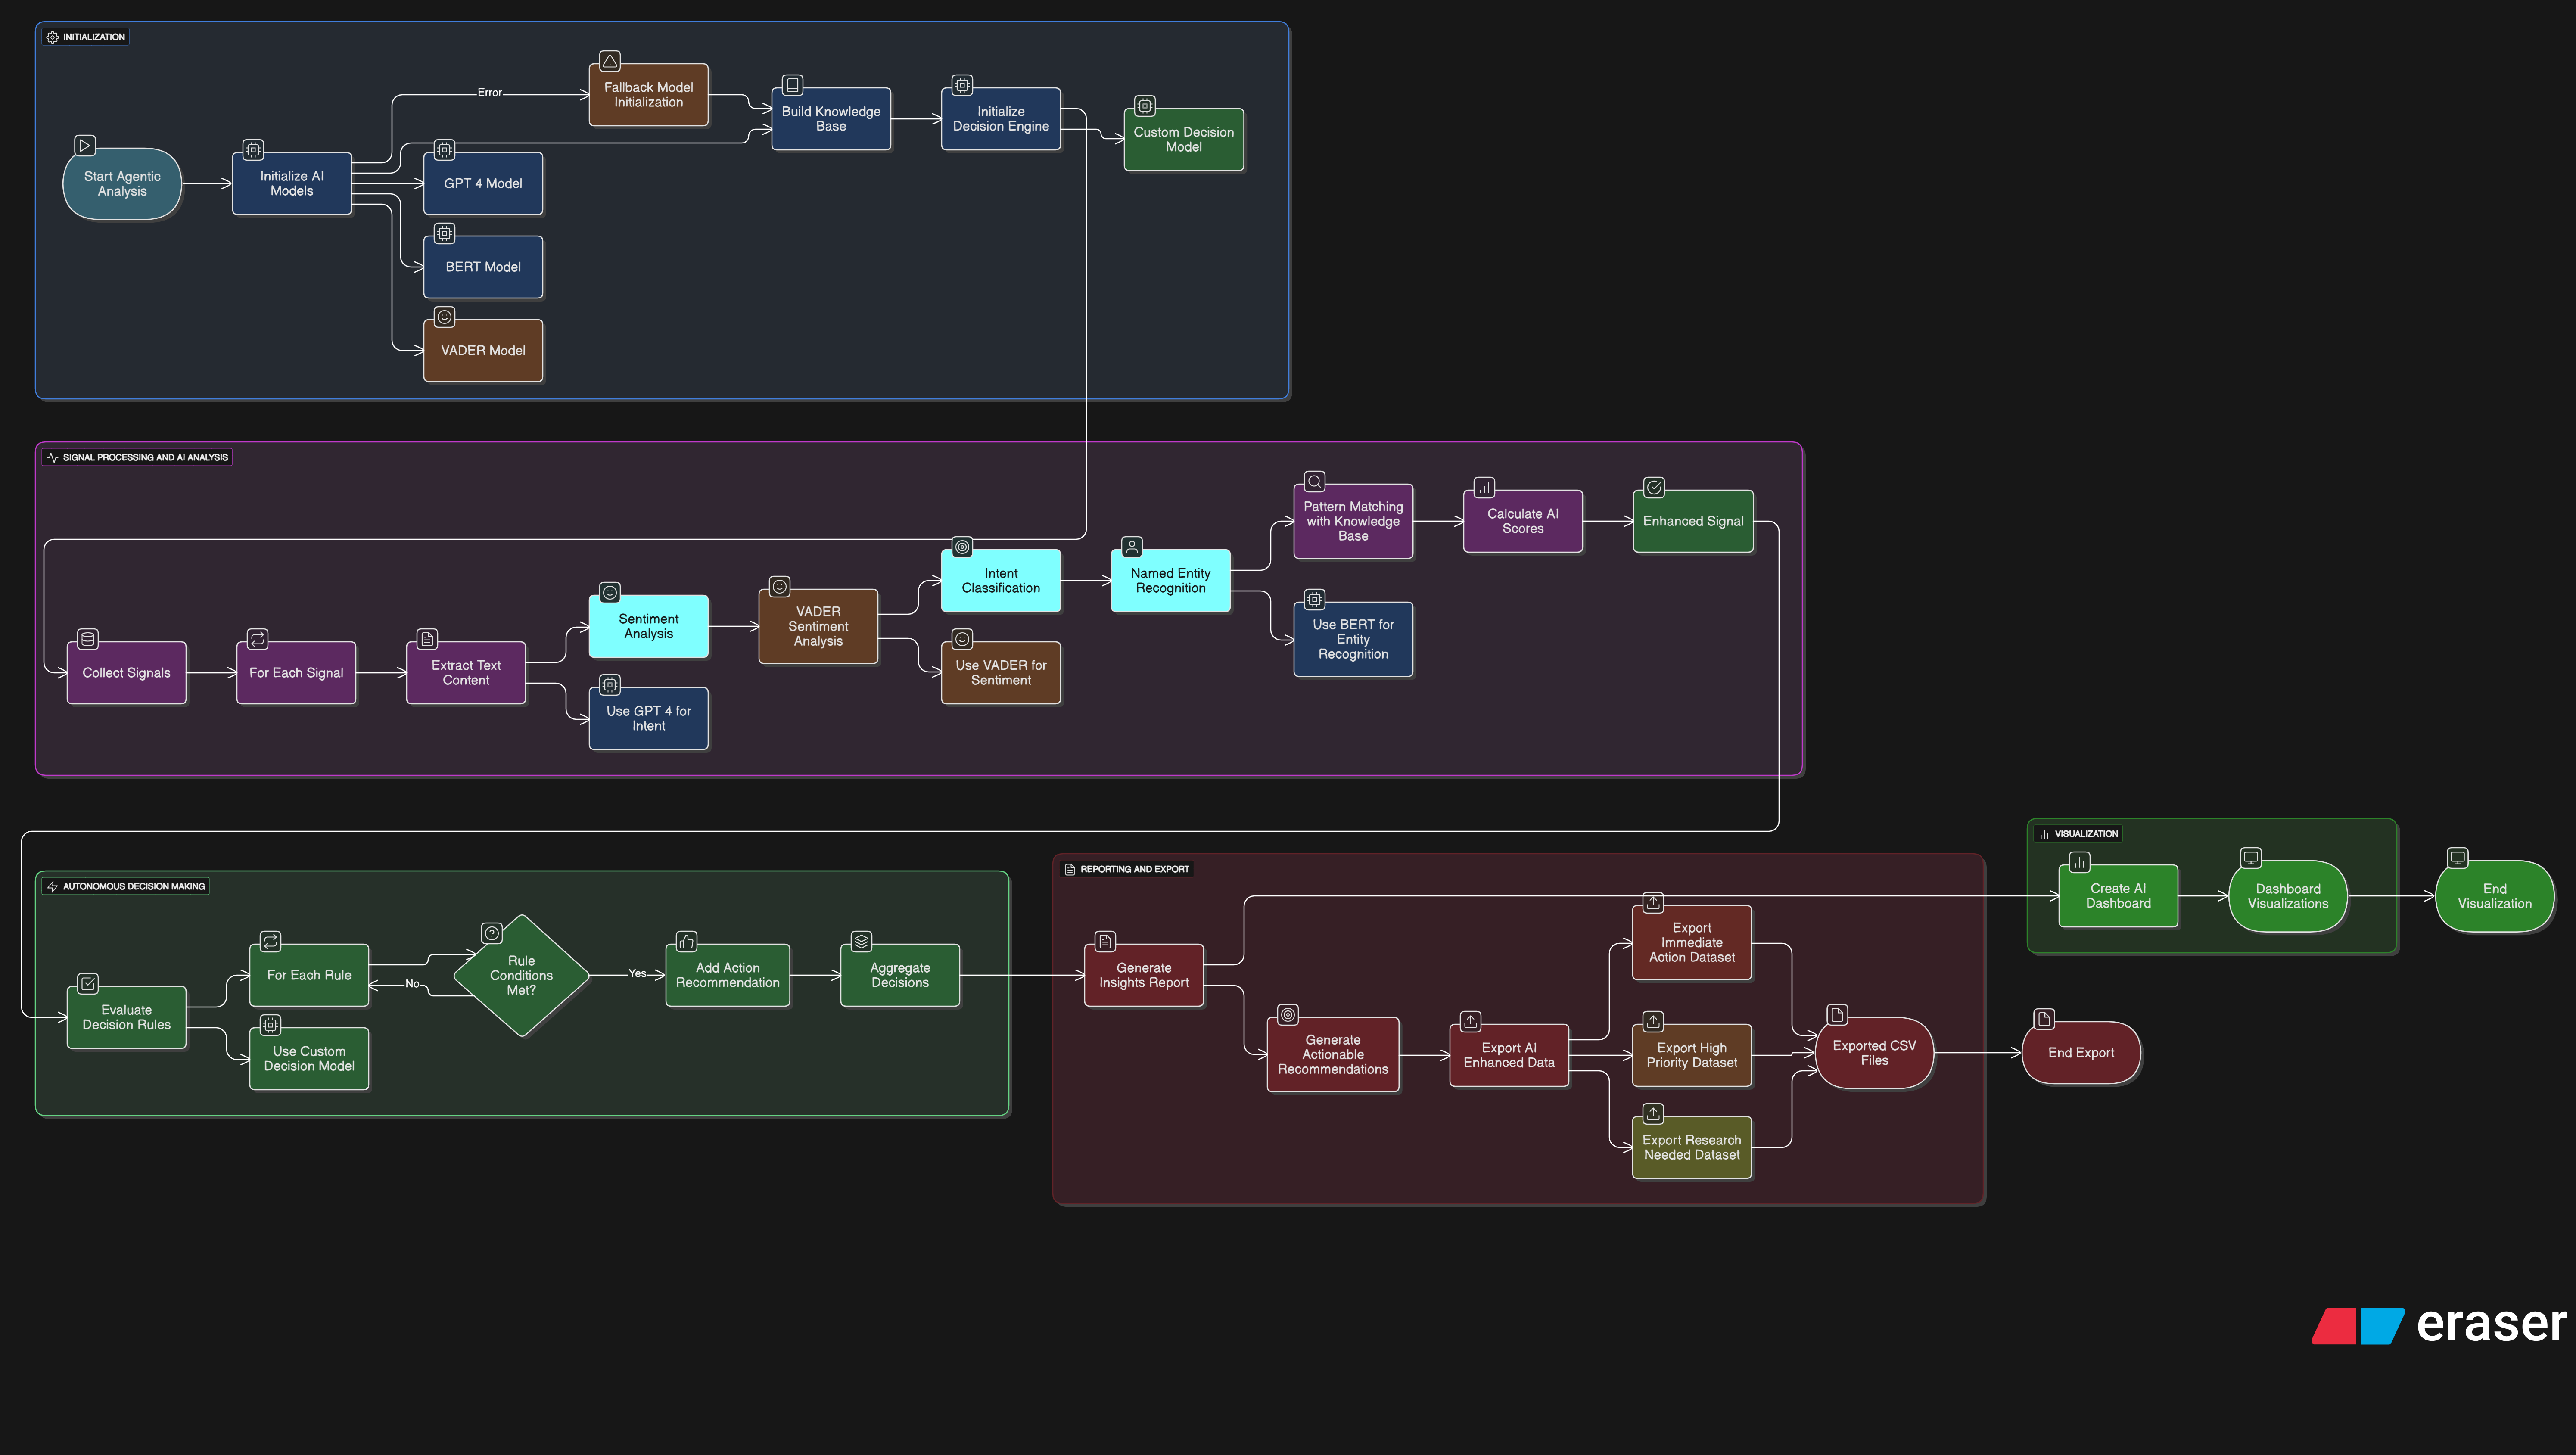

🚀 Starting Agentic Intent Signal Analysis...
🤖 Initializing AI-powered analysis components...
🤖 Initializing AI models...


config.json:   0%|          | 0.00/929 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/501M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/501M [00:00<?, ?B/s]

Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

Device set to use cuda:0


config.json:   0%|          | 0.00/1.15k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Device set to use cuda:0


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/998 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.33G [00:00<?, ?B/s]

Some weights of the model checkpoint at dbmdz/bert-large-cased-finetuned-conll03-english were not used when initializing BertForTokenClassification: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


tokenizer_config.json:   0%|          | 0.00/60.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

Device set to use cuda:0


✅ AI models loaded successfully
🔄 Processing 42 signals with AI...
  Processing signal 1/42: Shopify
  Processing signal 2/42: Shopify
  Processing signal 3/42: Shopify
  Processing signal 4/42: Shopify
  Processing signal 5/42: Shopify
  Processing signal 6/42: Stripe
  Processing signal 7/42: Stripe
  Processing signal 8/42: Stripe
  Processing signal 9/42: Stripe
  Processing signal 10/42: Stripe


You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


  Processing signal 11/42: HubSpot
  Processing signal 12/42: HubSpot
  Processing signal 13/42: HubSpot
  Processing signal 14/42: HubSpot
  Processing signal 15/42: HubSpot
  Processing signal 16/42: HubSpot
  Processing signal 17/42: HubSpot
  Processing signal 18/42: HubSpot
  Processing signal 19/42: Salesforce
  Processing signal 20/42: Salesforce
  Processing signal 21/42: Salesforce
  Processing signal 22/42: Salesforce
  Processing signal 23/42: Salesforce
  Processing signal 24/42: Salesforce
  Processing signal 25/42: Salesforce
  Processing signal 26/42: Salesforce
  Processing signal 27/42: Salesforce
  Processing signal 28/42: Salesforce
  Processing signal 29/42: Salesforce
  Processing signal 30/42: Salesforce
  Processing signal 31/42: Salesforce
  Processing signal 32/42: Salesforce
  Processing signal 33/42: Salesforce
  Processing signal 34/42: Slack
  Processing signal 35/42: Slack
  Processing signal 36/42: Slack
  Processing signal 37/42: Slack
  Processing signa

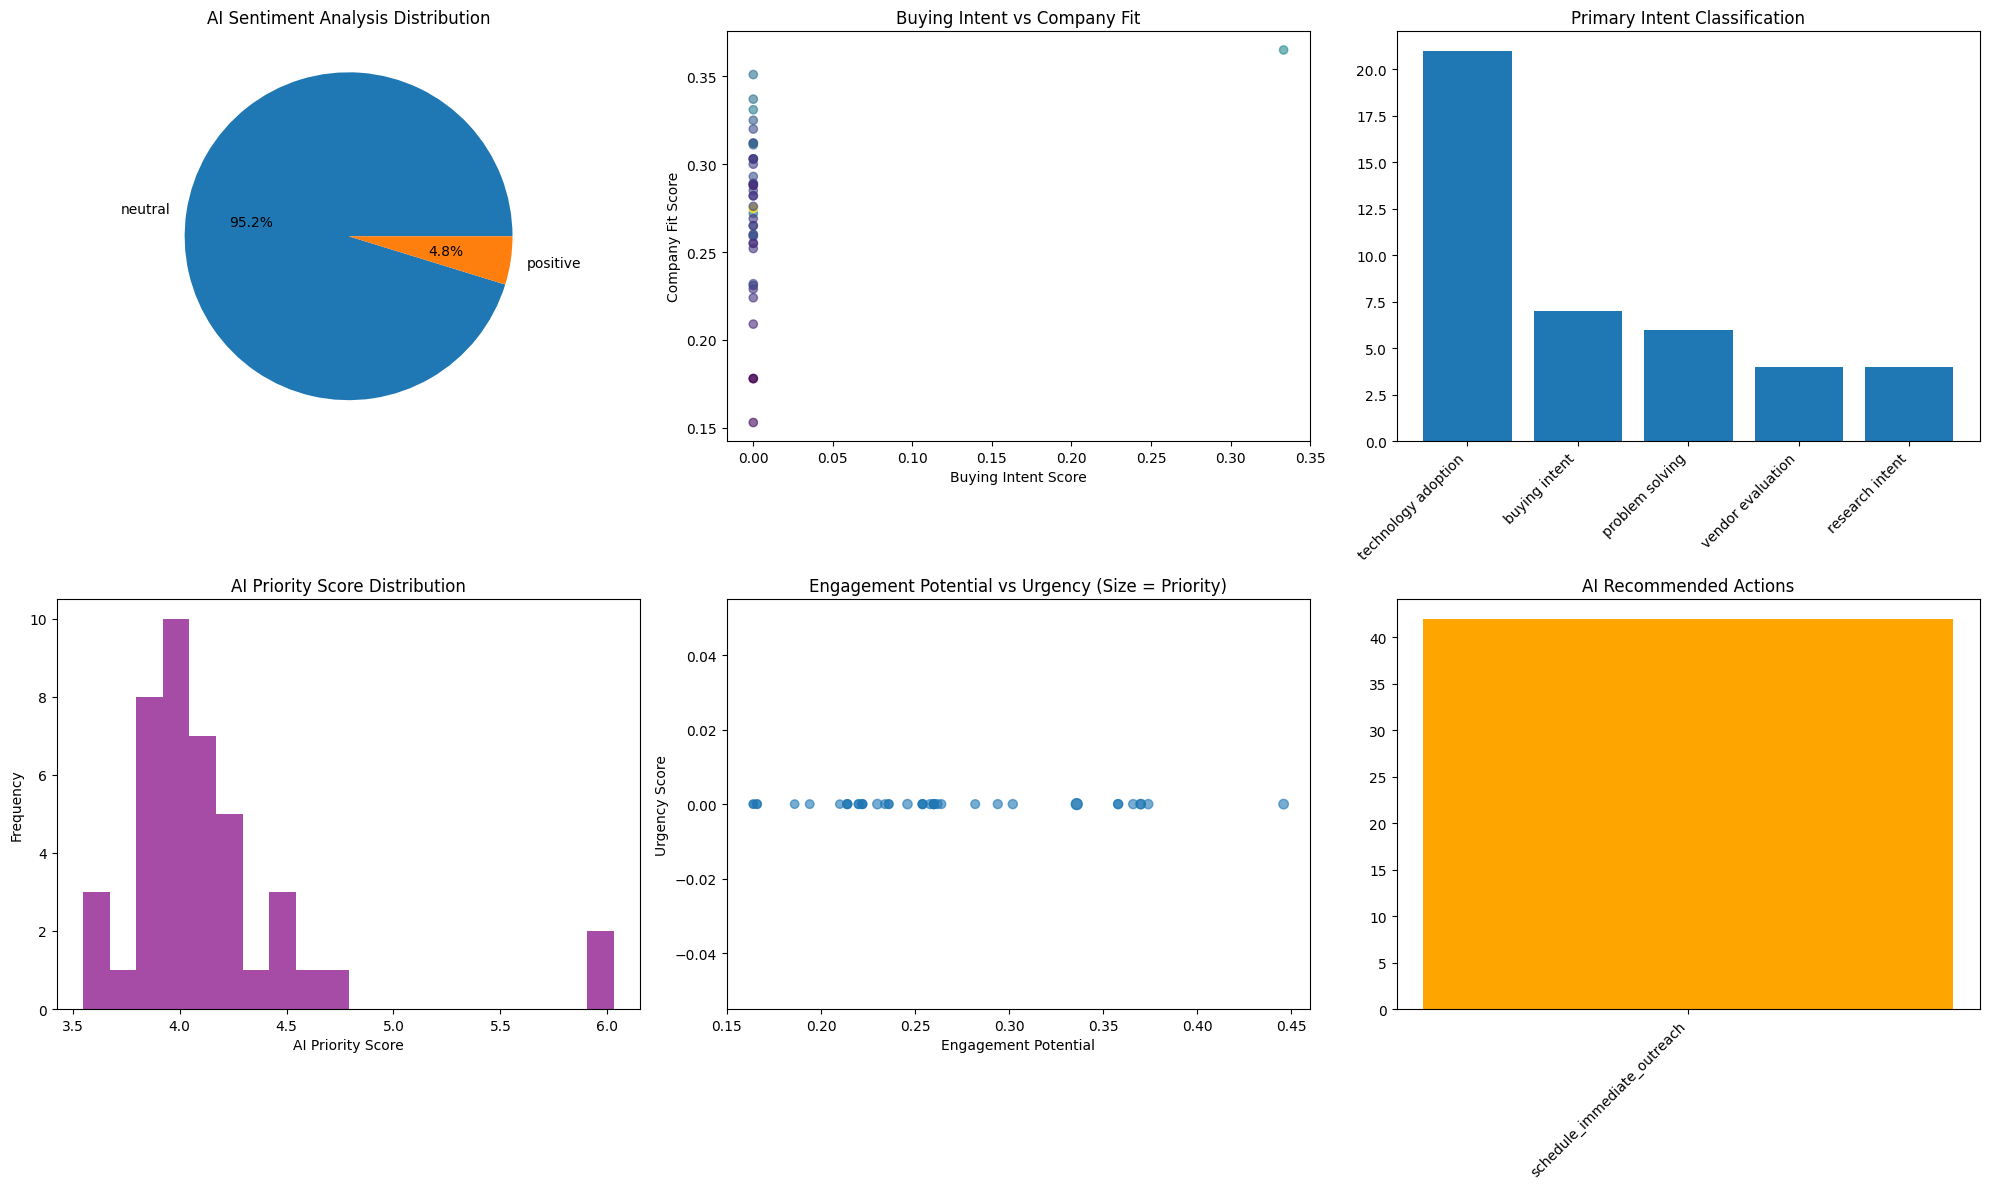

✅ AI Dashboard created successfully!

🎉 AGENTIC ANALYSIS COMPLETED!
📁 AI-Enhanced files generated:
  • ai_enhanced_intent_signals.csv - Complete AI analysis
  • immediate_action_signals.csv - Urgent follow-ups
  • high_priority_queue.csv - Priority prospects

🤖 The AI agent has analyzed your signals and made autonomous recommendations!
💡 Check the immediate action items for urgent follow-ups!


In [6]:
# Agentic Intent Signal Analysis Module
# Enhanced with AI-powered analysis and automated decision-making

# Install additional packages for AI capabilities
!pip install transformers torch sentence-transformers scikit-learn nltk textblob vaderSentiment openai-whisper groq

import numpy as np
from transformers import pipeline, AutoTokenizer, AutoModel
from sentence_transformers import SentenceTransformer
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import nltk
from textblob import TextBlob
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import re
from collections import defaultdict
import warnings
warnings.filterwarnings('ignore')

# Download required NLTK data
try:
    nltk.download('punkt', quiet=True)
    nltk.download('stopwords', quiet=True)
    nltk.download('vader_lexicon', quiet=True)
except:
    pass

class AgenticIntentAnalyzer:
    """
    AI-powered agentic module for intelligent intent signal analysis
    """

    def __init__(self, collector):
        self.collector = collector
        self.setup_ai_models()
        self.knowledge_base = self.build_knowledge_base()
        self.decision_engine = DecisionEngine()
        self.autonomous_actions = []

    def setup_ai_models(self):
        """Initialize pre-trained AI models for analysis"""
        print("🤖 Initializing AI models...")

        try:
            # Sentiment analysis pipeline
            self.sentiment_analyzer = pipeline(
                "sentiment-analysis",
                model="cardiffnlp/twitter-roberta-base-sentiment-latest",
                truncation=True,
                max_length=512
            )

            # Text classification for intent detection
            self.intent_classifier = pipeline(
                "zero-shot-classification",
                model="facebook/bart-large-mnli"
            )

            # Sentence embeddings for similarity analysis
            self.sentence_model = SentenceTransformer('all-MiniLM-L6-v2')

            # Named Entity Recognition
            self.ner_pipeline = pipeline(
                "ner",
                model="dbmdz/bert-large-cased-finetuned-conll03-english",
                aggregation_strategy="simple"
            )

            # VADER sentiment for backup
            self.vader = SentimentIntensityAnalyzer()

            print("✅ AI models loaded successfully")

        except Exception as e:
            print(f"⚠️ Error loading some AI models: {e}")
            # Fallback to basic models
            self.setup_fallback_models()

    def setup_fallback_models(self):
        """Setup basic models if advanced ones fail"""
        try:
            self.sentiment_analyzer = pipeline("sentiment-analysis")
            self.sentence_model = SentenceTransformer('all-MiniLM-L6-v2')
            self.vader = SentimentIntensityAnalyzer()
            print("✅ Fallback models loaded")
        except Exception as e:
            print(f"❌ Critical error loading models: {e}")

    def build_knowledge_base(self):
        """Build knowledge base of company and technology patterns"""
        return {
            'buying_signals': [
                'looking for', 'need help with', 'recommendation', 'comparison',
                'evaluation', 'budget', 'procurement', 'vendor selection',
                'implementation', 'migration', 'upgrade', 'replace'
            ],
            'pain_points': [
                'problem', 'issue', 'challenge', 'struggling', 'difficult',
                'frustrated', 'broken', 'not working', 'slow', 'expensive'
            ],
            'positive_indicators': [
                'funding', 'investment', 'growth', 'expansion', 'hiring',
                'success', 'achievement', 'breakthrough', 'launch', 'partnership'
            ],
            'urgency_indicators': [
                'urgent', 'asap', 'immediately', 'deadline', 'critical',
                'emergency', 'priority', 'time-sensitive', 'soon'
            ],
            'company_stages': {
                'startup': ['seed', 'series a', 'early stage', 'founding', 'mvp'],
                'growth': ['series b', 'series c', 'scaling', 'expansion', 'growing'],
                'enterprise': ['established', 'fortune', 'large', 'enterprise', 'corporate']
            },
            'tech_categories': {
                'crm': ['salesforce', 'hubspot', 'pipedrive', 'customer relationship'],
                'marketing': ['mailchimp', 'marketo', 'automation', 'campaign'],
                'productivity': ['slack', 'asana', 'monday', 'workflow', 'collaboration'],
                'development': ['github', 'jira', 'devops', 'api', 'integration'],
                'analytics': ['tableau', 'looker', 'dashboard', 'reporting', 'metrics']
            }
        }

class DecisionEngine:
    """
    Autonomous decision-making engine for intent signals
    """

    def __init__(self):
        self.decision_rules = self.setup_decision_rules()
        self.action_templates = self.setup_action_templates()

    def setup_decision_rules(self):
        """Define AI-driven decision rules"""
        return {
            'immediate_action': {
                'conditions': ['signal_strength >= 8', 'urgency_score > 0.7', 'buying_intent > 0.8'],
                'action': 'schedule_immediate_outreach'
            },
            'high_priority': {
                'conditions': ['signal_strength >= 6', 'company_fit_score > 0.7'],
                'action': 'add_to_priority_queue'
            },
            'nurture': {
                'conditions': ['signal_strength >= 4', 'engagement_potential > 0.5'],
                'action': 'add_to_nurture_campaign'
            },
            'research_needed': {
                'conditions': ['confidence_level < 0.6', 'entity_clarity < 0.5'],
                'action': 'schedule_research_task'
            }
        }

    def setup_action_templates(self):
        """Define automated action templates"""
        return {
            'email_outreach': {
                'subject_templates': [
                    "Saw your {signal_context} - here's how we can help",
                    "Quick question about your {technology} implementation",
                    "{company_name} + {our_solution} = potential partnership?"
                ],
                'personalization_points': [
                    'recent_signal', 'company_stage', 'tech_stack', 'pain_points'
                ]
            },
            'content_recommendation': {
                'case_studies': 'based on similar company profiles',
                'whitepapers': 'matching technology interests',
                'demos': 'relevant to identified use cases'
            },
            'follow_up_cadence': {
                'immediate': [1, 3, 7],  # days
                'high_priority': [3, 7, 14],
                'nurture': [7, 14, 30]
            }
        }

class AgenticProcessor:
    """
    Main agentic processing engine
    """

    def __init__(self, analyzer):
        self.analyzer = analyzer
        self.processed_signals = []
        self.autonomous_insights = []

    def analyze_signal_with_ai(self, signal):
        """Comprehensive AI analysis of a single signal"""
        enhanced_signal = signal.copy()

        try:
            # Extract text for analysis
            text_content = f"{signal.get('description', '')} {signal.get('content_snippet', '')}"

            # AI-powered sentiment analysis
            sentiment_result = self.analyzer.sentiment_analyzer(text_content[:512])
            enhanced_signal['ai_sentiment'] = sentiment_result[0]['label']
            enhanced_signal['ai_sentiment_score'] = sentiment_result[0]['score']

            # VADER sentiment as backup
            vader_scores = self.analyzer.vader.polarity_scores(text_content)
            enhanced_signal['vader_sentiment'] = vader_scores

            # Intent classification
            intent_labels = [
                'buying intent', 'research intent', 'comparison shopping',
                'problem solving', 'vendor evaluation', 'technology adoption'
            ]
            intent_result = self.analyzer.intent_classifier(text_content[:512], intent_labels)
            enhanced_signal['primary_intent'] = intent_result['labels'][0]
            enhanced_signal['intent_confidence'] = intent_result['scores'][0]

            # Named Entity Recognition
            entities = self.analyzer.ner_pipeline(text_content[:512])
            enhanced_signal['entities'] = [
                {'text': ent['word'], 'label': ent['entity_group'], 'confidence': ent['score']}
                for ent in entities if ent['score'] > 0.7
            ]

            # Knowledge base matching
            enhanced_signal.update(self.match_knowledge_patterns(text_content))

            # Calculate AI-driven scores
            enhanced_signal.update(self.calculate_ai_scores(enhanced_signal))

            return enhanced_signal

        except Exception as e:
            print(f"⚠️ Error in AI analysis: {e}")
            return enhanced_signal

    def match_knowledge_patterns(self, text):
        """Match text against knowledge base patterns"""
        text_lower = text.lower()
        kb = self.analyzer.knowledge_base

        # Buying signals detection
        buying_signals = sum(1 for signal in kb['buying_signals'] if signal in text_lower)
        buying_intent_score = min(1.0, buying_signals / 3)

        # Pain points detection
        pain_points = [point for point in kb['pain_points'] if point in text_lower]
        pain_score = min(1.0, len(pain_points) / 2)

        # Urgency detection
        urgency_indicators = [ind for ind in kb['urgency_indicators'] if ind in text_lower]
        urgency_score = min(1.0, len(urgency_indicators) / 2)

        # Company stage detection
        detected_stage = 'unknown'
        for stage, keywords in kb['company_stages'].items():
            if any(keyword in text_lower for keyword in keywords):
                detected_stage = stage
                break

        # Technology category detection
        tech_interests = []
        for category, keywords in kb['tech_categories'].items():
            if any(keyword in text_lower for keyword in keywords):
                tech_interests.append(category)

        return {
            'buying_intent_score': buying_intent_score,
            'pain_score': pain_score,
            'urgency_score': urgency_score,
            'detected_company_stage': detected_stage,
            'technology_interests': tech_interests,
            'matched_pain_points': pain_points,
            'urgency_indicators': urgency_indicators
        }

    def calculate_ai_scores(self, signal):
        """Calculate comprehensive AI-driven scores"""
        # Company fit score (based on multiple factors)
        company_fit_factors = [
            signal.get('buying_intent_score', 0) * 0.3,
            signal.get('intent_confidence', 0) * 0.2,
            signal.get('ai_sentiment_score', 0) * 0.2,
            (1 if signal.get('detected_company_stage') != 'unknown' else 0) * 0.15,
            (len(signal.get('technology_interests', [])) / 5) * 0.15
        ]
        company_fit_score = sum(company_fit_factors)

        # Engagement potential (likelihood of positive response)
        engagement_factors = [
            signal.get('urgency_score', 0) * 0.25,
            signal.get('pain_score', 0) * 0.25,
            signal.get('buying_intent_score', 0) * 0.3,
            (signal.get('engagement_score', 0) / 100) * 0.2
        ]
        engagement_potential = sum(engagement_factors)

        # Entity clarity (how well we understand the signal)
        entity_clarity = len(signal.get('entities', [])) / 5 if signal.get('entities') else 0.3

        # Composite priority score
        priority_score = (
            signal.get('signal_strength', 5) * 0.3 +
            company_fit_score * 10 * 0.25 +
            engagement_potential * 10 * 0.25 +
            signal.get('confidence_level', 0.5) * 10 * 0.2
        )

        return {
            'company_fit_score': round(company_fit_score, 3),
            'engagement_potential': round(engagement_potential, 3),
            'entity_clarity': round(entity_clarity, 3),
            'ai_priority_score': round(priority_score, 2)
        }

    def make_autonomous_decisions(self, enhanced_signal):
        """Make autonomous decisions based on AI analysis"""
        decisions = []
        rules = self.analyzer.decision_engine.decision_rules

        for rule_name, rule in rules.items():
            if self.evaluate_conditions(enhanced_signal, rule['conditions']):
                decisions.append({
                    'rule': rule_name,
                    'action': rule['action'],
                    'confidence': enhanced_signal.get('ai_priority_score', 5) / 10,
                    'reasoning': self.generate_reasoning(enhanced_signal, rule_name)
                })

        return decisions

    def evaluate_conditions(self, signal, conditions):
        """Evaluate rule conditions against signal data"""
        for condition in conditions:
            try:
                # Parse condition (e.g., 'signal_strength >= 8')
                parts = condition.replace('>=', '|>=|').replace('>', '|>|').replace('<', '|<|').replace('==', '|==|')
                for op in ['|>=|', '|>|', '|<|', '|==|']:
                    if op in parts:
                        field, operator, value = parts.split(op)
                        field = field.strip()
                        value = float(value.strip())
                        signal_value = signal.get(field, 0)

                        if operator == '|>=|' and signal_value >= value:
                            continue
                        elif operator == '|>|' and signal_value > value:
                            continue
                        elif operator == '|<|' and signal_value < value:
                            continue
                        elif operator == '|==|' and signal_value == value:
                            continue
                        else:
                            return False
            except:
                continue
        return True

    def generate_reasoning(self, signal, rule_name):
        """Generate human-readable reasoning for decisions"""
        reasoning_templates = {
            'immediate_action': f"High signal strength ({signal.get('signal_strength', 0)}) with strong buying intent ({signal.get('buying_intent_score', 0):.2f}) and urgency indicators detected.",
            'high_priority': f"Good company fit ({signal.get('company_fit_score', 0):.2f}) with solid signal strength ({signal.get('signal_strength', 0)}).",
            'nurture': f"Moderate engagement potential ({signal.get('engagement_potential', 0):.2f}) suggests nurturing opportunity.",
            'research_needed': f"Low confidence ({signal.get('confidence_level', 0):.2f}) requires additional research before action."
        }
        return reasoning_templates.get(rule_name, "Standard processing rule applied.")

class AgenticReportGenerator:
    """
    Generate intelligent reports with AI insights
    """

    def __init__(self, processor):
        self.processor = processor

    def generate_ai_insights_report(self):
        """Generate comprehensive AI-powered insights report"""
        signals = self.processor.processed_signals

        if not signals:
            print("❌ No processed signals available for AI insights")
            return

        print("\n" + "="*80)
        print("🤖 AI-POWERED INTENT SIGNAL INSIGHTS REPORT")
        print("="*80)

        # AI Analysis Overview
        total_signals = len(signals)
        high_intent_signals = len([s for s in signals if s.get('buying_intent_score', 0) > 0.6])
        urgent_signals = len([s for s in signals if s.get('urgency_score', 0) > 0.5])

        print(f"\n🧠 AI ANALYSIS OVERVIEW:")
        print(f"Total Analyzed Signals: {total_signals}")
        print(f"High Buying Intent: {high_intent_signals} ({high_intent_signals/total_signals*100:.1f}%)")
        print(f"Urgent Signals: {urgent_signals} ({urgent_signals/total_signals*100:.1f}%)")

        # Intent Distribution
        intent_distribution = defaultdict(int)
        for signal in signals:
            intent = signal.get('primary_intent', 'unknown')
            intent_distribution[intent] += 1

        print(f"\n🎯 INTENT DISTRIBUTION:")
        for intent, count in sorted(intent_distribution.items(), key=lambda x: x[1], reverse=True):
            percentage = count/total_signals*100
            print(f"  {intent}: {count} signals ({percentage:.1f}%)")

        # Sentiment Analysis
        sentiment_scores = [s.get('ai_sentiment_score', 0.5) for s in signals]
        avg_sentiment = sum(sentiment_scores) / len(sentiment_scores)
        positive_sentiment = len([s for s in signals if s.get('ai_sentiment') == 'POSITIVE'])

        print(f"\n😊 SENTIMENT ANALYSIS:")
        print(f"Average Sentiment Score: {avg_sentiment:.3f}")
        print(f"Positive Sentiment: {positive_sentiment} signals ({positive_sentiment/total_signals*100:.1f}%)")

        # Company Fit Analysis
        fit_scores = [s.get('company_fit_score', 0) for s in signals]
        high_fit_companies = [s for s in signals if s.get('company_fit_score', 0) > 0.7]

        print(f"\n🏢 COMPANY FIT ANALYSIS:")
        print(f"Average Company Fit Score: {sum(fit_scores)/len(fit_scores):.3f}")
        print(f"High-Fit Companies: {len(high_fit_companies)}")

        # Top AI-Recommended Actions
        all_decisions = []
        for signal in signals:
            if 'autonomous_decisions' in signal:
                all_decisions.extend(signal['autonomous_decisions'])

        if all_decisions:
            action_counts = defaultdict(int)
            for decision in all_decisions:
                action_counts[decision['action']] += 1

            print(f"\n🤖 TOP AI-RECOMMENDED ACTIONS:")
            for action, count in sorted(action_counts.items(), key=lambda x: x[1], reverse=True)[:5]:
                print(f"  {action}: {count} recommendations")

        # Technology Interest Trends
        all_tech_interests = []
        for signal in signals:
            all_tech_interests.extend(signal.get('technology_interests', []))

        if all_tech_interests:
            tech_counter = Counter(all_tech_interests)
            print(f"\n💻 TRENDING TECHNOLOGY INTERESTS:")
            for tech, count in tech_counter.most_common(5):
                print(f"  {tech}: {count} mentions")

        return self.generate_actionable_recommendations(signals)

    def generate_actionable_recommendations(self, signals):
        """Generate specific actionable recommendations"""
        print(f"\n🎯 AI-GENERATED ACTIONABLE RECOMMENDATIONS:")

        # Immediate action items
        immediate_actions = []
        high_priority_items = []
        research_items = []

        for signal in signals:
            decisions = signal.get('autonomous_decisions', [])
            for decision in decisions:
                item = {
                    'company': signal.get('company_name', 'Unknown'),
                    'description': signal.get('description', '')[:60] + '...',
                    'action': decision['action'],
                    'confidence': decision['confidence'],
                    'reasoning': decision['reasoning']
                }

                if decision['action'] == 'schedule_immediate_outreach':
                    immediate_actions.append(item)
                elif decision['action'] == 'add_to_priority_queue':
                    high_priority_items.append(item)
                elif decision['action'] == 'schedule_research_task':
                    research_items.append(item)

        # Display recommendations
        if immediate_actions:
            print(f"\n🚨 IMMEDIATE ACTIONS ({len(immediate_actions)} items):")
            for item in sorted(immediate_actions, key=lambda x: x['confidence'], reverse=True)[:5]:
                print(f"  • {item['company']}: {item['description']}")
                print(f"    Action: {item['action']} (Confidence: {item['confidence']:.2f})")
                print(f"    Reasoning: {item['reasoning']}")

        if high_priority_items:
            print(f"\n⭐ HIGH PRIORITY QUEUE ({len(high_priority_items)} items):")
            for item in sorted(high_priority_items, key=lambda x: x['confidence'], reverse=True)[:5]:
                print(f"  • {item['company']}: {item['description']}")

        if research_items:
            print(f"\n🔍 RESEARCH REQUIRED ({len(research_items)} items):")
            for item in research_items[:3]:
                print(f"  • {item['company']}: {item['description']}")

        return {
            'immediate_actions': immediate_actions,
            'high_priority': high_priority_items,
            'research_needed': research_items
        }

def run_agentic_analysis():
    """
    Main agentic analysis function
    """
    print("🚀 Starting Agentic Intent Signal Analysis...")
    print("="*60)

    # Check if we have collected signals
    if not hasattr(globals().get('collector'), 'detailed_signals') or not collector.detailed_signals:
        print("❌ No signals found. Please run the data collection pipeline first.")
        return None

    # Initialize agentic components
    print("🤖 Initializing AI-powered analysis components...")
    agentic_analyzer = AgenticIntentAnalyzer(collector)
    agentic_processor = AgenticProcessor(agentic_analyzer)

    # Process each signal with AI
    print(f"🔄 Processing {len(collector.detailed_signals)} signals with AI...")

    for i, signal in enumerate(collector.detailed_signals):
        print(f"  Processing signal {i+1}/{len(collector.detailed_signals)}: {signal.get('company_name', 'Unknown')}")

        # AI analysis
        enhanced_signal = agentic_processor.analyze_signal_with_ai(signal)

        # Autonomous decision making
        decisions = agentic_processor.make_autonomous_decisions(enhanced_signal)
        enhanced_signal['autonomous_decisions'] = decisions

        # Store processed signal
        agentic_processor.processed_signals.append(enhanced_signal)

    print(f"✅ AI analysis complete! Processed {len(agentic_processor.processed_signals)} signals")

    # Generate AI insights report
    report_generator = AgenticReportGenerator(agentic_processor)
    recommendations = report_generator.generate_ai_insights_report()

    # Export AI-enhanced data
    export_ai_enhanced_data(agentic_processor.processed_signals)

    return agentic_processor, recommendations

def export_ai_enhanced_data(processed_signals):
    """Export AI-enhanced signal data"""
    if not processed_signals:
        return

    # Create enhanced DataFrame
    enhanced_df = pd.DataFrame(processed_signals)

    # Flatten nested data for CSV export
    for idx, row in enhanced_df.iterrows():
        # Flatten entities
        if 'entities' in row and row['entities']:
            entity_texts = [ent['text'] for ent in row['entities']]
            enhanced_df.at[idx, 'extracted_entities'] = ', '.join(entity_texts)

        # Flatten autonomous decisions
        if 'autonomous_decisions' in row and row['autonomous_decisions']:
            decision_actions = [dec['action'] for dec in row['autonomous_decisions']]
            enhanced_df.at[idx, 'recommended_actions'] = ', '.join(decision_actions)

            # Get highest confidence decision
            best_decision = max(row['autonomous_decisions'], key=lambda x: x['confidence'])
            enhanced_df.at[idx, 'primary_recommendation'] = best_decision['action']
            enhanced_df.at[idx, 'recommendation_confidence'] = best_decision['confidence']
            enhanced_df.at[idx, 'ai_reasoning'] = best_decision['reasoning']

    # Export comprehensive AI-enhanced dataset
    enhanced_df.to_csv("ai_enhanced_intent_signals.csv", index=False, encoding='utf-8')
    print(f"✅ AI-enhanced data exported to ai_enhanced_intent_signals.csv")

    # Export action-specific datasets
    immediate_actions = enhanced_df[enhanced_df['recommended_actions'].str.contains('immediate_outreach', na=False)]
    if not immediate_actions.empty:
        immediate_actions.to_csv("immediate_action_signals.csv", index=False)
        print(f"✅ Immediate action signals exported ({len(immediate_actions)} records)")

    high_priority = enhanced_df[enhanced_df['recommended_actions'].str.contains('priority_queue', na=False)]
    if not high_priority.empty:
        high_priority.to_csv("high_priority_queue.csv", index=False)
        print(f"✅ High priority queue exported ({len(high_priority)} records)")

    return enhanced_df

def create_ai_dashboard():
    """Create interactive AI insights dashboard"""
    if not hasattr(globals().get('collector'), 'detailed_signals'):
        print("❌ No data available for dashboard")
        return

    # This would create visualizations of AI insights
    print("📊 Creating AI Insights Dashboard...")

    # Load processed data
    try:
        df = pd.read_csv("ai_enhanced_intent_signals.csv")

        # Create enhanced visualizations
        fig, axes = plt.subplots(2, 3, figsize=(20, 12))

        # AI Sentiment Distribution
        sentiment_counts = df['ai_sentiment'].value_counts()
        axes[0,0].pie(sentiment_counts.values, labels=sentiment_counts.index, autopct='%1.1f%%')
        axes[0,0].set_title('AI Sentiment Analysis Distribution')

        # Buying Intent vs Company Fit
        axes[0,1].scatter(df['buying_intent_score'], df['company_fit_score'],
                         alpha=0.6, c=df['ai_priority_score'], cmap='viridis')
        axes[0,1].set_xlabel('Buying Intent Score')
        axes[0,1].set_ylabel('Company Fit Score')
        axes[0,1].set_title('Buying Intent vs Company Fit')

        # Intent Classification Distribution
        intent_counts = df['primary_intent'].value_counts().head(6)
        axes[0,2].bar(range(len(intent_counts)), intent_counts.values)
        axes[0,2].set_xticks(range(len(intent_counts)))
        axes[0,2].set_xticklabels(intent_counts.index, rotation=45, ha='right')
        axes[0,2].set_title('Primary Intent Classification')

        # AI Priority Score Distribution
        axes[1,0].hist(df['ai_priority_score'], bins=20, alpha=0.7, color='purple')
        axes[1,0].set_xlabel('AI Priority Score')
        axes[1,0].set_ylabel('Frequency')
        axes[1,0].set_title('AI Priority Score Distribution')

        # Engagement Potential vs Urgency
        axes[1,1].scatter(df['engagement_potential'], df['urgency_score'],
                         alpha=0.6, s=df['ai_priority_score']*10)
        axes[1,1].set_xlabel('Engagement Potential')
        axes[1,1].set_ylabel('Urgency Score')
        axes[1,1].set_title('Engagement Potential vs Urgency (Size = Priority)')

        # Recommendation Actions Distribution
        if 'primary_recommendation' in df.columns:
            rec_counts = df['primary_recommendation'].value_counts()
            axes[1,2].bar(range(len(rec_counts)), rec_counts.values, color='orange')
            axes[1,2].set_xticks(range(len(rec_counts)))
            axes[1,2].set_xticklabels(rec_counts.index, rotation=45, ha='right')
            axes[1,2].set_title('AI Recommended Actions')

        plt.tight_layout()
        plt.show()

        print("✅ AI Dashboard created successfully!")

    except Exception as e:
        print(f"❌ Error creating dashboard: {e}")

# Main execution
if __name__ == "__main__":
    # Run the agentic analysis
    agentic_processor, ai_recommendations = run_agentic_analysis()

    # Create AI dashboard
    create_ai_dashboard()

    print(f"\n🎉 AGENTIC ANALYSIS COMPLETED!")
    print(f"📁 AI-Enhanced files generated:")
    print(f"  • ai_enhanced_intent_signals.csv - Complete AI analysis")
    print(f"  • immediate_action_signals.csv - Urgent follow-ups")
    print(f"  • high_priority_queue.csv - Priority prospects")
    print(f"\n🤖 The AI agent has analyzed your signals and made autonomous recommendations!")
    print(f"💡 Check the immediate action items for urgent follow-ups!")

In [3]:
# Install required packages and setup Streamlit UI
!pip install streamlit plotly streamlit-aggrid pyngrok -q

# Create the Streamlit app file
streamlit_app = '''
import streamlit as st
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import numpy as np
from datetime import datetime, timedelta
import json
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

# Set page config
st.set_page_config(
    page_title="🤖 AI-Powered Intent Signal Dashboard",
    page_icon="🤖",
    layout="wide",
    initial_sidebar_state="expanded"
)

# Custom CSS for better styling
st.markdown("""
<style>
    .main-header {
        background: linear-gradient(90deg, #667eea 0%, #764ba2 100%);
        padding: 1rem;
        border-radius: 10px;
        color: white;
        text-align: center;
        margin-bottom: 2rem;
    }
    .metric-card {
        background: white;
        padding: 1rem;
        border-radius: 10px;
        box-shadow: 0 2px 4px rgba(0,0,0,0.1);
        border-left: 4px solid #667eea;
    }
    .status-badge {
        padding: 0.25rem 0.75rem;
        border-radius: 15px;
        font-size: 0.8rem;
        font-weight: bold;
        margin: 0.2rem;
    }
    .urgent { background-color: #ff4757; color: white; }
    .high-priority { background-color: #ffa502; color: white; }
    .normal { background-color: #2ed573; color: white; }
    .research { background-color: #3742fa; color: white; }
    .stTabs [data-baseweb="tab-list"] {
        gap: 24px;
    }
    .stTabs [data-baseweb="tab"] {
        height: 50px;
        padding-left: 20px;
        padding-right: 20px;
    }
</style>
""", unsafe_allow_html=True)

@st.cache_data
def load_ai_data():
    """Load AI-enhanced data from CSV files"""
    try:
        # Try to load the main AI-enhanced dataset
        df = pd.read_csv("ai_enhanced_intent_signals.csv")
        return df
    except FileNotFoundError:
        # If no AI data exists, create sample data for demo
        st.warning("⚠️ No AI-enhanced data found. Generating sample data for demonstration.")
        return create_sample_data()

def create_sample_data():
    """Create sample data for demonstration purposes"""
    np.random.seed(42)
    n_samples = 50

    companies = [f"TechCorp_{i}" for i in range(1, n_samples+1)]
    intents = ['buying intent', 'research intent', 'comparison shopping', 'problem solving', 'vendor evaluation']
    sentiments = ['POSITIVE', 'NEGATIVE', 'NEUTRAL']
    actions = ['schedule_immediate_outreach', 'add_to_priority_queue', 'add_to_nurture_campaign', 'schedule_research_task']

    data = {
        'company_name': companies,
        'ai_sentiment': np.random.choice(sentiments, n_samples, p=[0.4, 0.2, 0.4]),
        'ai_sentiment_score': np.random.uniform(0.5, 0.99, n_samples),
        'primary_intent': np.random.choice(intents, n_samples),
        'intent_confidence': np.random.uniform(0.6, 0.95, n_samples),
        'buying_intent_score': np.random.uniform(0.1, 1.0, n_samples),
        'company_fit_score': np.random.uniform(0.2, 1.0, n_samples),
        'engagement_potential': np.random.uniform(0.3, 1.0, n_samples),
        'urgency_score': np.random.uniform(0.0, 1.0, n_samples),
        'ai_priority_score': np.random.uniform(3.0, 9.5, n_samples),
        'primary_recommendation': np.random.choice(actions, n_samples),
        'recommendation_confidence': np.random.uniform(0.5, 0.95, n_samples),
        'signal_strength': np.random.randint(3, 10, n_samples),
        'technology_interests': [', '.join(np.random.choice(['CRM', 'Marketing', 'Analytics', 'DevOps'],
                                np.random.randint(1, 4))) for _ in range(n_samples)],
        'description': [f"Signal description for {comp}" for comp in companies]
    }

    return pd.DataFrame(data)

def get_priority_badge(action):
    """Get priority badge HTML based on action"""
    if action == 'schedule_immediate_outreach':
        return '<span class="status-badge urgent">🚨 URGENT</span>'
    elif action == 'add_to_priority_queue':
        return '<span class="status-badge high-priority">⭐ HIGH PRIORITY</span>'
    elif action == 'add_to_nurture_campaign':
        return '<span class="status-badge normal">🌱 NURTURE</span>'
    elif action == 'schedule_research_task':
        return '<span class="status-badge research">🔍 RESEARCH</span>'
    else:
        return '<span class="status-badge normal">📝 STANDARD</span>'

def create_overview_dashboard(df):
    """Create overview dashboard with key metrics"""
    st.markdown('<div class="main-header"><h1>🤖 AI-Powered Intent Signal Analysis Dashboard</h1></div>',
                unsafe_allow_html=True)

    # Key Metrics Row
    col1, col2, col3, col4, col5 = st.columns(5)

    with col1:
        total_signals = len(df)
        st.metric("📊 Total Signals", total_signals)

    with col2:
        high_intent = len(df[df['buying_intent_score'] > 0.7])
        st.metric("🎯 High Intent", high_intent, f"{high_intent/total_signals*100:.1f}%")

    with col3:
        urgent_signals = len(df[df['primary_recommendation'] == 'schedule_immediate_outreach'])
        st.metric("🚨 Urgent Actions", urgent_signals)

    with col4:
        avg_priority = df['ai_priority_score'].mean()
        st.metric("⭐ Avg Priority", f"{avg_priority:.1f}/10")

    with col5:
        positive_sentiment = len(df[df['ai_sentiment'] == 'POSITIVE'])
        st.metric("😊 Positive Sentiment", f"{positive_sentiment/total_signals*100:.1f}%")

    # Charts Row
    col1, col2 = st.columns(2)

    with col1:
        st.subheader("🎯 Intent Distribution")
        intent_counts = df['primary_intent'].value_counts()
        fig = px.pie(values=intent_counts.values, names=intent_counts.index,
                    color_discrete_sequence=px.colors.qualitative.Set3)
        fig.update_traces(textposition='inside', textinfo='percent+label')
        st.plotly_chart(fig, use_container_width=True)

    with col2:
        st.subheader("📊 AI Priority Score Distribution")
        fig = px.histogram(df, x='ai_priority_score', nbins=20,
                          color_discrete_sequence=['#667eea'])
        fig.update_layout(xaxis_title="AI Priority Score", yaxis_title="Count")
        st.plotly_chart(fig, use_container_width=True)

def create_detailed_analysis(df):
    """Create detailed analysis charts"""
    st.header("📈 Detailed AI Analysis")

    # Sentiment vs Intent Analysis
    col1, col2 = st.columns(2)

    with col1:
        st.subheader("😊 Sentiment Analysis")
        sentiment_counts = df['ai_sentiment'].value_counts()
        colors = {'POSITIVE': '#2ed573', 'NEGATIVE': '#ff4757', 'NEUTRAL': '#ffa502'}
        fig = px.bar(x=sentiment_counts.index, y=sentiment_counts.values,
                    color=sentiment_counts.index, color_discrete_map=colors)
        fig.update_layout(showlegend=False, xaxis_title="Sentiment", yaxis_title="Count")
        st.plotly_chart(fig, use_container_width=True)

    with col2:
        st.subheader("🎯 Buying Intent vs Company Fit")
        fig = px.scatter(df, x='buying_intent_score', y='company_fit_score',
                        color='ai_priority_score', size='urgency_score',
                        hover_data=['company_name', 'primary_intent'])
        fig.update_layout(xaxis_title="Buying Intent Score", yaxis_title="Company Fit Score")
        st.plotly_chart(fig, use_container_width=True)

    # Technology Interest Analysis
    st.subheader("💻 Technology Interest Analysis")

    # Extract and count technology interests
    all_tech = []
    for tech_list in df['technology_interests'].dropna():
        all_tech.extend([tech.strip() for tech in str(tech_list).split(',')])

    tech_counter = Counter(all_tech)
    tech_df = pd.DataFrame(tech_counter.most_common(10), columns=['Technology', 'Count'])

    fig = px.bar(tech_df, x='Technology', y='Count', color='Count',
                color_continuous_scale='viridis')
    fig.update_layout(xaxis_title="Technology", yaxis_title="Mentions")
    st.plotly_chart(fig, use_container_width=True)

def create_action_queue(df):
    """Create action queue interface"""
    st.header("🎯 AI-Recommended Action Queue")

    # Action type filter
    action_types = ['All'] + list(df['primary_recommendation'].unique())
    selected_action = st.selectbox("Filter by Action Type:", action_types)

    # Filter data
    if selected_action != 'All':
        filtered_df = df[df['primary_recommendation'] == selected_action]
    else:
        filtered_df = df

    # Sort by priority score
    filtered_df = filtered_df.sort_values('ai_priority_score', ascending=False)

    # Display action items
    for idx, row in filtered_df.head(20).iterrows():
        with st.container():
            col1, col2, col3, col4 = st.columns([3, 2, 2, 1])

            with col1:
                st.markdown(f"**{row['company_name']}**")
                st.markdown(f"*{row.get('description', 'No description available')[:60]}...*")

            with col2:
                st.markdown(get_priority_badge(row['primary_recommendation']),
                           unsafe_allow_html=True)
                st.markdown(f"**Intent:** {row['primary_intent']}")

            with col3:
                st.markdown(f"**Priority Score:** {row['ai_priority_score']:.1f}/10")
                st.markdown(f"**Confidence:** {row['recommendation_confidence']:.1f}")

            with col4:
                if st.button(f"Take Action", key=f"action_{idx}"):
                    st.success(f"Action initiated for {row['company_name']}")

            st.divider()

def create_analytics_dashboard(df):
    """Create advanced analytics dashboard"""
    st.header("📊 Advanced Analytics")

    # Filters
    col1, col2, col3 = st.columns(3)

    with col1:
        min_priority = st.slider("Minimum Priority Score", 0.0, 10.0, 0.0)

    with col2:
        sentiment_filter = st.multiselect("Sentiment Filter",
                                        df['ai_sentiment'].unique(),
                                        default=df['ai_sentiment'].unique())

    with col3:
        intent_filter = st.multiselect("Intent Filter",
                                     df['primary_intent'].unique(),
                                     default=df['primary_intent'].unique())

    # Apply filters
    filtered_df = df[
        (df['ai_priority_score'] >= min_priority) &
        (df['ai_sentiment'].isin(sentiment_filter)) &
        (df['primary_intent'].isin(intent_filter))
    ]

    st.write(f"Showing {len(filtered_df)} signals (filtered from {len(df)} total)")

    # Advanced charts
    col1, col2 = st.columns(2)

    with col1:
        st.subheader("🎯 Engagement Potential vs Urgency")
        fig = px.scatter(filtered_df, x='engagement_potential', y='urgency_score',
                        color='primary_recommendation', size='ai_priority_score',
                        hover_data=['company_name'])
        st.plotly_chart(fig, use_container_width=True)

    with col2:
        st.subheader("📈 Priority Score vs Intent Confidence")
        fig = px.scatter(filtered_df, x='intent_confidence', y='ai_priority_score',
                        color='ai_sentiment', hover_data=['company_name'])
        st.plotly_chart(fig, use_container_width=True)

    # Data table
    st.subheader("📋 Detailed Signal Data")

    # Select columns to display
    display_cols = st.multiselect("Select columns to display:",
                                 filtered_df.columns.tolist(),
                                 default=['company_name', 'primary_intent', 'ai_priority_score',
                                         'buying_intent_score', 'primary_recommendation'])

    if display_cols:
        st.dataframe(filtered_df[display_cols], use_container_width=True)

def main():
    """Main application function"""
    # Load data
    df = load_ai_data()

    if df.empty:
        st.error("❌ No data available. Please run the analysis pipeline first.")
        return

    # Sidebar navigation
    st.sidebar.title("🤖 Navigation")

    pages = {
        "📊 Overview": create_overview_dashboard,
        "📈 Detailed Analysis": create_detailed_analysis,
        "🎯 Action Queue": create_action_queue,
        "📊 Advanced Analytics": create_analytics_dashboard
    }

    selected_page = st.sidebar.selectbox("Select Page:", list(pages.keys()))

    # Sidebar info
    st.sidebar.markdown("---")
    st.sidebar.markdown("### 📊 Quick Stats")
    st.sidebar.metric("Total Signals", len(df))
    st.sidebar.metric("Avg Priority", f"{df['ai_priority_score'].mean():.1f}")
    st.sidebar.metric("High Intent", len(df[df['buying_intent_score'] > 0.7]))

    # Display selected page
    pages[selected_page](df)

    # Footer
    st.markdown("---")
    st.markdown("### 🔄 Data Refresh")
    if st.button("Refresh Data"):
        st.cache_data.clear()
        st.rerun()

if __name__ == "__main__":
    main()
'''

# Write the Streamlit app to a file
with open('streamlit_app.py', 'w') as f:
    f.write(streamlit_app)

print("✅ Streamlit app created successfully!")
print("📁 File saved as: streamlit_app.py")

# Setup ngrok for external access (optional)
print("\n🌐 Setting up external access...")
!pip install pyngrok -q

# Run Streamlit in the background
import subprocess
import threading
import time

def run_streamlit():
    subprocess.run(['streamlit', 'run', 'streamlit_app.py', '--server.port=8501', '--server.headless=true'])

# Start Streamlit in a separate thread
streamlit_thread = threading.Thread(target=run_streamlit)
streamlit_thread.daemon = True
streamlit_thread.start()

print("🚀 Starting Streamlit server...")
time.sleep(5)

# Setup ngrok tunnel
from pyngrok import ngrok
ngrok.set_auth_token("2xrybHG97nEirCJ2R3kmkWVZ6fX_59i8tD49kzsNbDCdexxfP")
# Create tunnel
public_url = ngrok.connect(8501)
print(f"\n✅ Streamlit app is running!")
print(f"🌐 Public URL: {public_url}")
print(f"📱 Local URL: http://localhost:8501")

print(f"\n🎯 Your AI-Powered Intent Signal Dashboard is ready!")
print(f"🔗 Click the public URL above to access your dashboard")
print(f"📊 The dashboard includes:")
print(f"   • Overview with key metrics")
print(f"   • Detailed AI analysis charts")
print(f"   • Action queue for immediate tasks")
print(f"   • Advanced analytics with filters")
print(f"\n💡 The app will automatically load your AI-enhanced data or generate sample data for demo.")

✅ Streamlit app created successfully!
📁 File saved as: streamlit_app.py

🌐 Setting up external access...
🚀 Starting Streamlit server...

✅ Streamlit app is running!
🌐 Public URL: NgrokTunnel: "https://2c54-34-32-162-171.ngrok-free.app" -> "http://localhost:8501"
📱 Local URL: http://localhost:8501

🎯 Your AI-Powered Intent Signal Dashboard is ready!
🔗 Click the public URL above to access your dashboard
📊 The dashboard includes:
   • Overview with key metrics
   • Detailed AI analysis charts
   • Action queue for immediate tasks
   • Advanced analytics with filters

💡 The app will automatically load your AI-enhanced data or generate sample data for demo.
